# Import packages

In [1310]:
from array import array
import itertools
import time
import math

import sys
sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#import astroML.plotting as aml
#import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter
from ROOT import TLatex

# File

In [1311]:
pPb_File = 'InputData/13def_SE_GMB_new_Ratio.root'
pp_File = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
MC_File = 'InputData/18b10a_pthat_1_2_SE_NN_Correlation_GMB_Ratio.root'
#pPb_File = 'InputData/13def_SE_L0_Correlation_GMB_Ratio.root'
#pp_File = 'InputData/17q_SE_L0_Correlation_GMB_Ratio.root'
#pPb_File = 'InputData/13def_EMax_SE_GMB_Ratio.root'
#pp_File = 'InputData/17q_SE_EMax_Correlation_GMB_Ratio.root'


#RootFile = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/13def_SE_GMB_new_Ratio.root'
#RootFile = 'InputData/13def_SE_GMB_new_Ratio.root'
RootFile = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
#RootFile = 'InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root'


# Define Bins and Purity


In [1312]:
#FIXME: Read from Corr_config.yaml
#zTbins = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]
pTbins = [0,0,12, 15]
#purity = [1, 1, 0.352546]
purity = [1,1,26.15]
NzT = 7
Corrections = [1,1.007,0.982,0.970,0.942,0.830,0.640]
#purity = [1,1,0.271083]
#purity = [1,1,0.2989]
#purity_NN = 0.352546
#purity_LO = 0.271083

# Define Errors

In [1313]:
p_error_sys = 0.06
p_error_stat = 0.028
eff_error = 0.05

# Prefix

In [1314]:
prefix = '13def'
#prefix = '18b10a'
#prefix = '18b10a'
#prefix = '18b10a_15_20'
#prefix = '13def_15_20'
#prefix = 'p-Pb'
#prefix = 'P-bp'
#prefix = 'pp'
#prefix = 'pp_mix'
#prefix = 'pp_Same_Only'

## Plot Titles

In [1315]:
def Plot1D (histo, ptbin, ztbin,DNN_Bool):
    #histo.SetTitle("#gamma - h : p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"
    #               %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    
    histo.SetTitle("#gamma - h: p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"%(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    
    histo.GetXaxis().SetTitle("#Delta#phi")
    histo.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    #histo.GetYaxis().SetTitle("#frac{d^{2}N}{d#phid#eta}")
    #histo.GetYaxis().SetTitleSize(0.035)
    #histo.GetYaxis().SetTitleOffset(1)
    histo.GetXaxis().CenterTitle(1)
    histo.GetXaxis().SetTitleOffset(0.6)
    histo.GetXaxis().SetTitleSize(0.06)
    
    histo.GetYaxis().SetTitleSize(0.05)
    histo.GetYaxis().SetTitleOffset(1.5)
    
    ROOT.gStyle.SetOptStat("")
    ROOT.gStyle.SetPalette(ROOT.kViridis)
    histo.SetLineWidth(1)
    histo.SetLineColor(4)
    histo.SetMarkerColor(4)
    if not(DNN_Bool):
        histo.SetLineColor(2)
        histo.SetMarkerColor(2)

# Label

In [1316]:
def DrawLabel2(Signal_DNN = True):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    if (Signal_DNN == "inclusive"):
        #latex.SetTextSize(0.04)
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.31,0.83, "#color[1]{p-Pb + Pb-p Inclusive}")
        else:
            latex.DrawLatex(0.31,0.83, "#color[1]{%s Inclusive}"%(prefix))
            
    elif (Signal_DNN):
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.31,0.83, "#color[4]{p-Pb + Pb-p Signal Region}")
        else:
            latex.DrawLatex(0.31,0.83, "#color[4]{%s Signal}"%(prefix))
            
    else:
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.31,0.83, "#color[2]{p-Pb + Pb-p Bkgd Region}")
        else:
            latex.DrawLatex(0.31,0.83, "#color[2]{%s Bkgnd}"%(prefix))

<sup> **Note** Scaling is done cell by cell (despite Axis title here) for accurate subtraction<sup>

# ZYAM

In [1317]:
def Subtract_ZYAM (PhiProjection):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow

    #zyam = PhiProjection.Integral(3,4)/2
    Z_min = (PhiProjection.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (PhiProjection.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam = PhiProjection.Integral(Z_min,Z_max)/(Z_N)

    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-zyam
            PhiProjection.SetBinContent(i,new_y)
            #assumes 0 error in ZYAM
            new_y_error = y_error
            PhiProjection.SetBinError(i,new_y_error)

In [1318]:
def ZYAM_Line(hsig):
    Z_min = (hsig.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (hsig.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam_value = hsig.Integral(Z_min,Z_max)/(Z_N)
    
    #Errors
    Z_Error = 0
    for NError in range(Z_min,Z_max+1):
        Z_Error += (hsig.GetBinError(NError))**2
    Z_Error = math.sqrt(Z_Error)
    
    #LE TGraph
    NBins = hsig.GetSize()-2
    ZYAM = ROOT.TGraphErrors()
    for NBin in range(0,NBins+1):
        ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
        ZYAM.SetPointError(NBin,0,Z_Error)
    
    #print "zyam line value: ",zyam_value 
    #ZYAM.SetFillColorAlpha(7, 0.6);
    ZYAM.SetFillColor(7)
    SetOwnership(ZYAM, 0)
    
    #print Z_min, Z_max, Z_N
    #ZYAM = ROOT.TLine(0,zyam_value,math.pi,zyam_value)
    #ZYAM.SetLineColorAlpha(7, 0.9)
    #ZYAM.SetLineWidth(5)
    #SetOwnership(ZYAM, 0)
    
    return ZYAM

# N Triggers

In [1319]:
def Get_NTriggers(filename,prfx,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "inclusive"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        if (prfx =="18b10a"):
            NTriggers = ntrig_histo.Integral(0,-1)
        else:
            NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

# Large $\eta$

In [1320]:
def GetLEProj(filename, ipt, izt, Signal_DNN=True):
    file = ROOT.TFile(filename)
    
    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    
    if (Signal_DNN == "inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        
        LE_Projection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-1.2),Eta_Axis.FindBin(-0.8))
                                        #10*zTbins[izt+1]),5,11)
        LE_Projection_pos = histo2D.ProjectionX('PosEta_inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                    100*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.2))
  
        ntriggers = Get_NTriggers(filename,prefix, ipt, Signal_DNN)  
        if not(ntriggers == None):
            LE_Projection.Scale(1.0/ntriggers) #per trigger yield
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        
        histo2D_1 = file.Get('DNN1_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                             %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        histo2D_2 = file.Get('DNN2_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                             %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
#         histo2D_1 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
#                             %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
#         histo2D_2 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
#                             %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
      
        
        #Project
        Eta_Axis = histo2D_1.GetYaxis()
        
#        ntriggers_DNN1 = Get_NTriggers(filename,prefix, ipt, Signal_DNN) 
        
        ntriggers_DNN1 = Get_NTriggers(filename,prefix, ipt, True)
        ntriggers_DNN2 = Get_NTriggers(filename,prefix, ipt, False)       
    
        LE_Projection = histo2D_1.ProjectionX('NegEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))
        
        LE_Projection_pos = histo2D_1.ProjectionX('PosEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))    
        
        LE_Projection_DNN2 = histo2D_2.ProjectionX('NegEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))

        LE_Projection_DNN2_pos = histo2D_2.ProjectionX('PosEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))
        
        LE_Projection.Scale(1.0/ntriggers_DNN1)
        LE_Projection_pos.Scale(1.0/ntriggers_DNN1)
        
        LE_Projection_DNN2.Scale(1.0/ntriggers_DNN2)
        LE_Projection_DNN2_pos.Scale(1.0/ntriggers_DNN2)
        
        
        LE_Projection.Add(LE_Projection_DNN2,1)
        LE_Projection.Scale(0.5)
        
        LE_Projection_pos.Add(LE_Projection_DNN2_pos,1)
        LE_Projection_pos.Scale(0.5)
        
    
    #Add,scale 
    LE_Projection.SetDirectory(0)
    LE_Projection.Add(LE_Projection_pos,1)
    LE_Projection.Rebin(2)
    LE_Projection.Scale(1.0/1.2) #scale by eta region
    #LE_Projection.Scale(1.0/2.8)
    Plot1D(LE_Projection,ipt,izt,Signal_DNN)
    LE_Projection.SetMarkerStyle(25)
    LE_Projection.SetLineColorAlpha(1,0.1)
    #LE_PhiProjection.SetMarkerSize(3)
    LE_Projection.SetMarkerColor(1)
        
    #Legend
    #legend = ROOT.TLegend(0.64,0.78,0.89,0.88)
    legend = ROOT.TLegend(0.3,0.69,0.6,0.80)
    legend.SetBorderSize(0)
    LE_Projection.SetLineColorAlpha(1,0.9) #8 for light green
    #legend.AddEntry(LE_PhiProjection, "0.8 <|#eta| < 1.4","p")
    SetOwnership(legend, 0)
    file.Close()
    return LE_Projection,legend

#### Simplify above with calls to getPhiProjection()

In [1321]:
def GetLE_Line(LE_Proj):
    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    LE_value = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    #print LE_value
    
    #Errors
    Temp_Error = 0
    for NError in range(LE_min,LE_max+1):
        Temp_Error += (LE_Proj.GetBinError(NError))**2
    #print Temp_Error
    
    Temp_Error = math.sqrt(Temp_Error)
    LE_Error = Temp_Error/(LE_max-LE_min+1)
    #LE_Error = LE_Error/math.sqrt(10000)
    
    #LE TGraph
    NBins = LE_Proj.GetSize()-2
    LE_Line = ROOT.TGraphErrors()
    for NBin in range(0,NBins+1):
        LE_Line.SetPoint(NBin,(NBin*math.pi/NBins),LE_value)
        LE_Line.SetPointError(NBin,0,LE_Error)
    
    print "LE Line Value: ","%1.3f"%(LE_value)," +/- ","%1.3f"%(LE_Error)
    
    #LE_Line.SetFillColorAlpha(1, 0.9);
    LE_Line.SetFillColor(17);
    #LE_Line = ROOT.TLine(0,LE_value,math.pi,LE_value)
    #LE_Line.SetLineColorAlpha(1, 0.9)
    #LE_Line.SetLineWidth(5)
    SetOwnership(LE_Line, 0)
    #legend
    legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
    legend.AddEntry(LE_Line, "0.8 <|#eta| < 1.4","l")
    SetOwnership(legend, 0)
    return LE_Line,legend

In [1322]:
def GetLE_Val(LE_Proj):
    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    LE_value = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    Temp_Error = 0
    for NError in range(LE_min,LE_max+1):
        Temp_Error += (LE_Proj.GetBinError(NError))**2
        
    Temp_Error = math.sqrt(Temp_Error)
    LE_Error = Temp_Error/(LE_max-LE_min+1)
    
    return LE_value, LE_Error

In [1323]:
def Subtract_LE(PhiProjection,LE_Proj,DoSys=False):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow    

    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    LE = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    LE_Error = 0
    for NError in range(LE_min,LE_max):
        LE_Error += (LE_Proj.GetBinError(NError))**2
    #print "Quad Sum of Errors:",LE_Error
    LE_Error = math.sqrt(LE_Error)
    LE_Error = LE_Error/(LE_N)
    #print "SQRT N:",math.sqrt(LE_N)
    #print "After SQRT and /SQRT(N):",LE_Error

    #print "LE Value: ",LE," +/- ",LE_Error
    #print "LE Error:",LE_Error
    sumerror=0
    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-LE
            PhiProjection.SetBinContent(i,new_y)
            if (DoSys):
                new_y_error = math.sqrt(LE_Error**2) #Propagate the systematic by itself
                #new_y_error = 0
            else:
                new_y_error = y_error    
            PhiProjection.SetBinError(i,new_y_error)

    #print math.sqrt(sumerror)

#### Check

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: cav


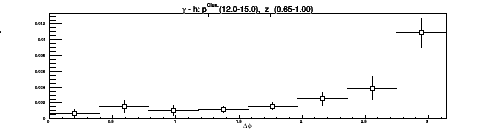

(0.0012535391869423927, 0.0003393770011155075)

In [1324]:
LE,legend = GetLEProj(RootFile, 2, 6, True)
cav = ROOT.TCanvas("cav","cav", 500,160)
LE.Draw()
legend.Draw()
cav.Draw()
#GetLE_Line(LE)
GetLE_Val(LE)

<sup>**NOTE**: The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>

# Get Phi Projection

In [1325]:
def GetPhiProj(filename,prfx,ipt, izt, Signal_DNN=True, doZYAM=True,DoSys=False):
    file = ROOT.TFile(filename)

    if (DoSys):
        SysE = "_Stat+Sys"
    else:
        SysE = ""
    
    if (Signal_DNN == "inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f%s' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(1.4))
                                        #10*zTbins[izt+1]),5,11)
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f%s' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(1.4))
        
                                        #100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                        #10*zTbins[izt+1]),5,11)
    
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    #PhiProjection.Scale(1.0/1.2)
    PhiProjection.Scale((1.0/2.8))
    #scale by eta region
    #PhiProjection.SetMarkerStyle(20)
    
    ntriggers = Get_NTriggers(filename,prfx,ipt, Signal_DNN)
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers) #per trigger yield
        
        
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)    
    if(doZYAM):
        LE_Proj,legend = GetLEProj(filename, ipt, izt, Signal_DNN)
        #Subtract_LE(PhiProjection,LE_Proj,DoSys)#Stat+Sys Bool (True, False = Just Stat.)
        Subtract_ZYAM(PhiProjection)
    
    file.Close()
    return PhiProjection

In [1326]:
for ztbin in range(6):
    GetPhiProj(RootFile,prefix,2,ztbin,True,True,True) #Signal=Yes,ZYAM=No,SysError=No.

<sup>**NOTE**: SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed. Root is annoying.</sup>

# Compare ZYAM and LE

In [1327]:
for ipt in range (3):
    if (ipt > 0): continue
    ipt = ipt+2
    for izt in range (6):
        Sig_LE_Proj,legend = GetLEProj(RootFile, ipt, izt, False)
        S_LE, S_LE_Error = GetLE_Val(Sig_LE_Proj)
        
        Bkg_LE_Proj,legend = GetLEProj(RootFile, ipt, izt, False)
        B_LE, B_LE_Error = GetLE_Val(Bkg_LE_Proj)       
        
        hsig =  GetPhiProj(RootFile,prefix,ipt,izt,True,False,False)
        hbkg = GetPhiProj(RootFile,prefix,ipt,izt,False,False,False)
        
        sig_line = ZYAM_Line(hsig)
        bkg_line = ZYAM_Line(hbkg)
        NBins = hsig.GetSize()-2
        
        z_sig = sig_line.GetY()
        z_bkg = bkg_line.GetY()
        
        ztemp = 0
        ztemp = (z_sig[1] + z_bkg[1])/2
        z_sig_error = sig_line.GetErrorY(1)
        z_bkg_error = bkg_line.GetErrorY(1)
        z_error = math.sqrt(z_sig_error**2 + z_bkg_error**2)/2
        #print "%1.4f"%(z_error)
        #print "%1.3f"%((z_bkg[1]+z_sig[1])/2)
        #print ztemp, z_error
        print "%.3f"%(S_LE),"+/-","%.3f"%(S_LE_Error)
        #print "%.3f"%(z_bkg[1]),"+/-","%.3f"%(z_bkg_error)
        Diff_Error = math.sqrt(z_error**2 + S_LE_Error**2)
        Diff = ztemp - S_LE
        #print "%.3f"%(Diff),"+/-","%.3f"%(Diff_Error)

0.180 +/- 0.002
0.122 +/- 0.002
0.061 +/- 0.001
0.024 +/- 0.001
0.007 +/- 0.000
0.004 +/- 0.001


### Side By Side

In [1328]:
def SideSide(Region):
        RootFile = pPb_File
        prefix = "13def"
        print RootFile
        Uncorr = True
        DoSub = False
        DoSys = False
        ptbin = 0
        ptbin = ptbin+2;
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        #canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),10000,8000)
        
        if (Region=="regions"):
            #canvases.Divide(2,1)
            canvases.Divide(4,4)
        elif(Region=="inclusive"):
            canvases.Divide(3,2)
            
        for ztbin in range(7):
                
            if (Region=="regions"):              
            #grab
                hsig = GetPhiProj(RootFile,prefix,ptbin,ztbin,True,DoSub,False) #[DNN],[Subtraction Bool] [DoSysErr]
                hbkg = GetPhiProj(RootFile,prefix,ptbin,ztbin,False,DoSub,False)
                ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
                
                if (DoSys):
                    hsig_sys = GetPhiProj(RootFile,prefix,ptbin,ztbin,True,DoSub,True)
                    hbkg_sys = GetPhiProj(RootFile,prefix,ptbin,ztbin,False,DoSub,True)
                
                if not(DoSub):
                    hsig.GetYaxis().SetRangeUser(0,ymax)
                    hbkg.GetYaxis().SetRangeUser(0,ymax)  
                if (DoSub):
                    ymin = 1.4*min(hsig.GetMinimum(),hbkg.GetMinimum())
                    hsig.GetYaxis().SetRangeUser(ymin,ymax)
                    hbkg.GetYaxis().SetRangeUser(ymin,ymax)    
                
                canvases.cd(ztbin*2+1)
                ROOT.gPad.SetLeftMargin(0.18)
                ROOT.gPad.SetRightMargin(0.0)
                #canvases.cd(ztbin+1)
                Sig_ZYAM= ZYAM_Line(hsig) #Change to UnCorr_Line, swith to high rapidity
                LE_sig,legend = GetLEProj(RootFile, ptbin, ztbin,True)
                LE_Line,temp = GetLE_Line(LE_sig)
                
                if (DoSys):
                    hsig_sys.SetLineColor(1)
                    hsig_sys.Draw()
                    hsig.Draw("sameE1")
                else:    
                    hsig.Draw()  
                DrawLabel2(True)
                if(Uncorr):
                    Sig_ZYAM.Draw("same3")
                    LE_Line.Draw("same3")
                    hsig.Draw("same")
                    LE_sig.SetLineWidth(1)
                    LE_sig.Draw("sameE1")
                    #legend.AddEntry(hsig,"High DNN","p")
                    legend.AddEntry(LE_sig, "0.8 <|#Delta#eta| < 1.4","p")
                    legend.AddEntry(LE_Line, "#LT Large #Delta#eta #GT","f")
                    legend.AddEntry(Sig_ZYAM, "ZYAM","f")
                    legend.Draw("same")

            if (Region=="inclusive"):
                    hsig = GetPhiProj(RootFile,prefix,ptbin,ztbin,"inclusive",False,False)
                    ymax = 1.2*hsig.GetMaximum()
                    hsig.GetYaxis().SetRangeUser(0,ymax)
                    canvases.cd(ztbin+1) 
                    ROOT.gPad.SetLeftMargin(0.18)
                    ROOT.gPad.SetRightMargin(0.0)
                    hsig.Draw()  
                    DrawLabel2("inclusive")
                    
                
            #Background
            if (Region=="regions"): 
                canvases.cd(ztbin*2+2)
                ROOT.gPad.SetLeftMargin(0.18)
                ROOT.gPad.SetRightMargin(0.0)
                BKG_ZYAM = ZYAM_Line(hbkg)
                LE_bkg,legend = GetLEProj(RootFile, ptbin, ztbin, False)
                LE_bkg_Line,temp = GetLE_Line(LE_bkg)
                
                if (DoSys):
                    hbkg_sys.SetLineColor(1)
                    hbkg_sys.Draw()
                    hbkg.Draw("sameE1")
                else:
                    hbkg.Draw()
                DrawLabel2(False)
                if (Uncorr):
                    BKG_ZYAM.Draw("same3")
                    LE_bkg_Line.Draw("same3")
                    hbkg.Draw("same")
                    LE_bkg.SetLineWidth(1)
                    LE_bkg.Draw("sameE1")
                    #legend.AddEntry(hbkg,"Low DNN","p")
                    legend.AddEntry(LE_bkg, "0.8 <|#Delta#eta| < 1.4","p")
                    legend.AddEntry(LE_bkg_Line, "#LT Large #Delta#eta #GT","f")
                    legend.AddEntry(BKG_ZYAM, "ZYAM","f")
                    legend.Draw("same")
                #canvases.SaveAs("pics/%s_Phi_2DNN_zT__%1.0f_%1.0f.pdf"%(prefix,100*zTbins[ztbin],100*zTbins[ztbin+1]))
        canvases.Update()
        canvases.Draw()
        if (Region=="inclusive"):
            canvases.SaveAs("pics/%s_Inclusive_Phi.pdf"%(prefix))
            canvases.SaveAs("pics/%s_Inclusive_Phi.png"%(prefix))
        if (Region=="regions"):
            if(Uncorr):
                canvases.SaveAs("pics/%s_Phi_2DNN_Uncorr.pdf"%(prefix))
                canvases.SaveAs("pics/%s_Phi_2DNN_Uncorr.png"%(prefix))
            else:
                canvases.SaveAs("pics/%s_Phi_2DNN.pdf"%(prefix))
                canvases.SaveAs("pics/%s_Phi_2DNN.png"%(prefix))
        return canvases
#myText(.2,.2,"hello_%i"%number,1) ‹›

InputData/13def_SE_GMB_new_Ratio.root
LE Line Value:  0.455  +/-  0.003
LE Line Value:  0.455  +/-  0.003
LE Line Value:  0.316  +/-  0.002
LE Line Value:  0.316  +/-  0.002
LE Line Value:  0.166  +/-  0.002
LE Line Value:  0.166  +/-  0.002
LE Line Value:  0.061  +/-  0.001
LE Line Value:  0.061  +/-  0.001
LE Line Value:  0.017  +/-  0.001
LE Line Value:  0.017  +/-  0.001
LE Line Value:  0.004  +/-  0.000
LE Line Value:  0.004  +/-  0.000
LE Line Value:  0.001  +/-  0.000
LE Line Value:  0.001  +/-  0.000


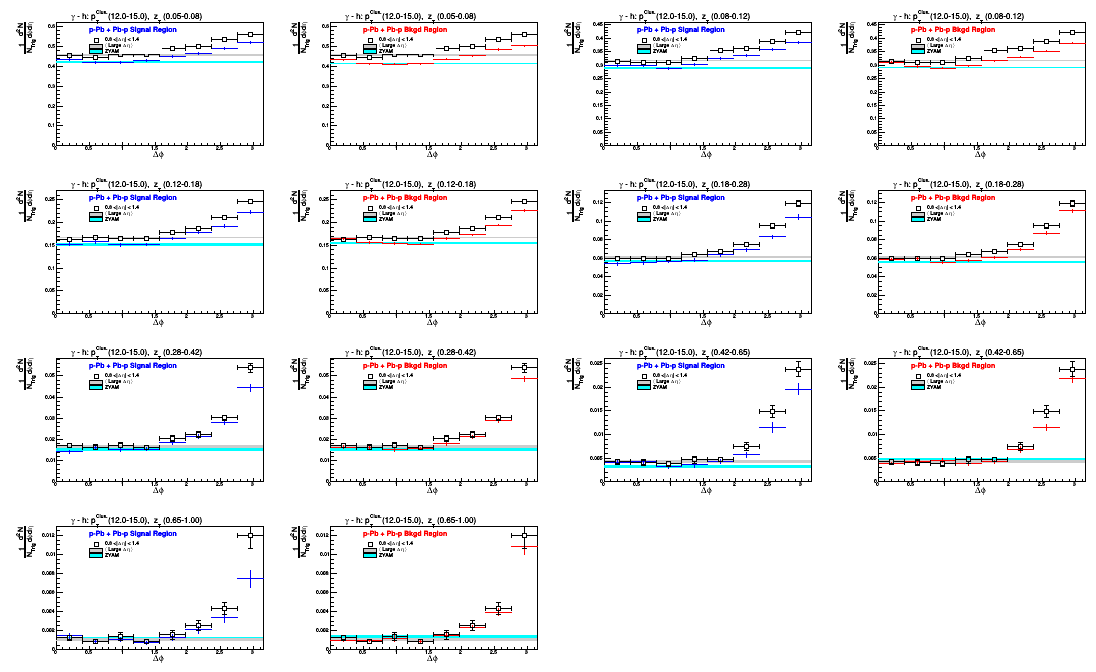

<ROOT.TCanvas object ("Canv_Side_Side_2") at 0x13d11bd0>

Info in <TCanvas::Print>: pdf file pics/13def_Phi_2DNN_Uncorr.pdf has been created
Info in <TCanvas::Print>: png file pics/13def_Phi_2DNN_Uncorr.png has been created


In [1329]:
SideSide("regions")
#SideSide("inclusive")

In [1330]:
def DrawLabel(NTriggers,ptbin):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.03)
    latex.DrawLatex(0.6,0.81, "#color[2]{purity = %1.2f}"%(purity[ptbin]))
    #latex.DrawLatex(0.12,0.85, "#color[2]{no purity scaling}")
    latex.DrawLatex(0.22,0.81, "#color[4]{%1.0f Triggers}"%(NTriggers))

In [1331]:
def DrawLabel3(NTriggers,DoSub=True):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.03)
    if (DoSub):
        latex.SetTextSize(0.04)
        #latex.DrawLatex(0.12,0.85, "#color[4]{%1.0f Triggers}"%(NTriggers))
        if (prefix=="13def"):
            latex.DrawLatex(0.22,0.85, "#color[4]{pPb+Pbp After Subtraction}")
        else:
            latex.DrawLatex(0.22,0.85, "#color[4]{%s After Subtraction}"%(prefix))
    else: 
        if (prefix=="13def"):
            latex.DrawLatex(0.22,0.85, "#color[4]{p-Pb+Pb-p Signal Region}")
            latex.DrawLatex(0.6,0.85, "#color[2]{(1-p)Bkgnd Region}")
        else:
            latex.DrawLatex(0.22,0.85, "#color[4]{%s Signal Region}"%(prefix))
            latex.DrawLatex(0.6,0.85, "#color[2]{%s (1-p)Bkgnd Region}"%(prefix))

# Calculate Purity Uncertainty

In [1332]:
def Get_P_Error(filename,prfx,p_err,doZYAM=True, doSubtraction=True, DoSys=False):
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    P_Error = []
    FF_P = []
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,2)

        for ztbin in range(7):
            canvases.cd(ztbin+1)
            Signal_minp = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_minp = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
            
            Signal_maxp = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_maxp = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)

            nbins = Signal.GetSize()-2
        
            #p_error = math.sqrt(0.028**2 + 0.06**2)
            p_min = purity[ptbin]-p_err
            p_max = purity[ptbin]+p_err

            Background_maxp.Scale((1-p_max)/p_max)
            Signal_maxp.Scale(1/p_max)
            #Background_maxp.Scale(1-p_max)
            Signal_maxp.Add(Background_maxp,-1)
            #Signal_maxp.Scale(1/p_max)
            #Signal_maxp.
            
            
            Background_minp.Scale((1-p_min)/p_min)
            Signal_minp.Scale(1/p_min)
            Signal_minp.Add(Background_minp,-1) 
            
            Background.Scale((1-purity[ptbin])/purity[ptbin])
            Signal.Scale(1/purity[ptbin])
            Signal.Add(Background,-1)

            y_min = -1.1*abs(Signal_minp.GetMinimum())
            y_max = 1.2*Signal_maxp.GetMaximum()
            
            Signal_maxp.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_maxp.Draw()
            Signal_minp.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_minp.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{p+#sigma_{p}}")
            latex.DrawLatex(0.14,0.79, "#color[3]{p = 0.35}")
            latex.DrawLatex(0.14,0.74, "#color[2]{p-#sigma_{p}}")

            #Signal.Add(Signal2,-1)
            p_error = []
            
            sum_p_error = 0
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal_maxp.GetBinContent(i)-Signal_minp.GetBinContent(i))/2
                sum_min += Signal_minp.GetBinContent(i)
                sum_max += Signal_maxp.GetBinContent(i)
                #print Signal_minp.GetBinContent(i)
            #print "sum_min: ",sum_min
            #print sum_min
        
            #print ""
            #print "max",sum_max
            #print "min",sum_min
            #delta = (sum_max - sum_min)/(2)
            #print "Delta/2 = ",delta
            #print "Sum over phi = ",sum_phi
            p_error.append(delta/sum_phi)
            #print sum_max        
            #print "Relative:",abs(delta/sum_phi*100),"%"
            #print "%1.2f"%(abs(delta/sum_phi)*100)
            P_Error.append(delta)
            #print P_Error[ztbin]
            FF_P.append(sum_phi)
        canvases.Update()
        canvases.Draw()
        canvases.SaveAs('pics/%s_P_sys_Var.pdf'%(prfx))
    return FF_P,P_Error

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: Canv_Side_Side_2


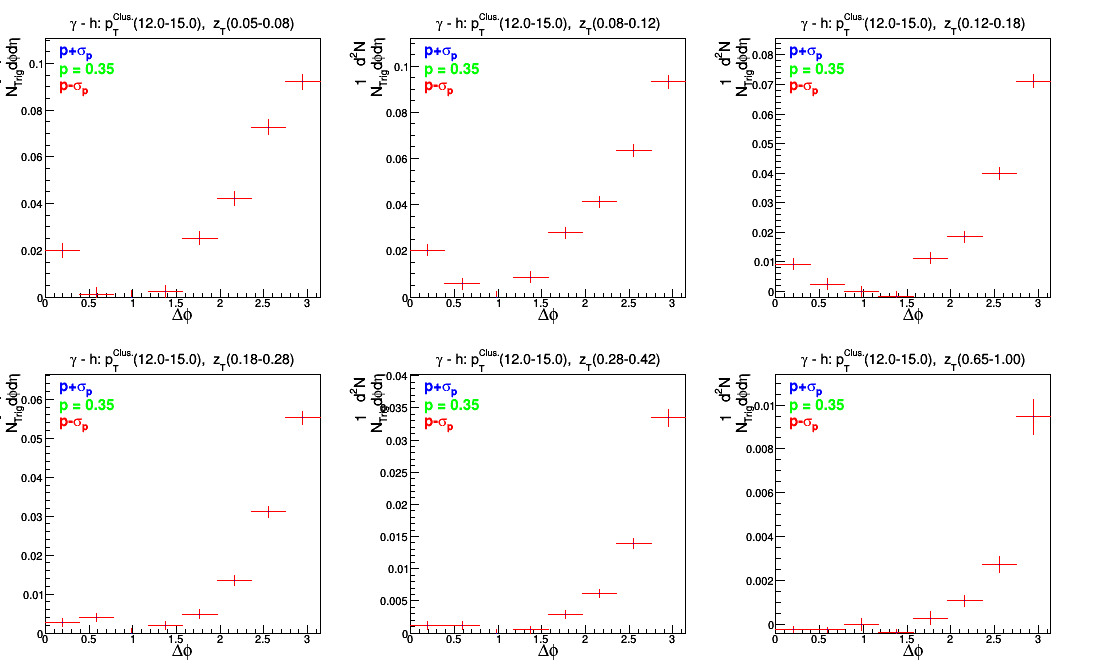

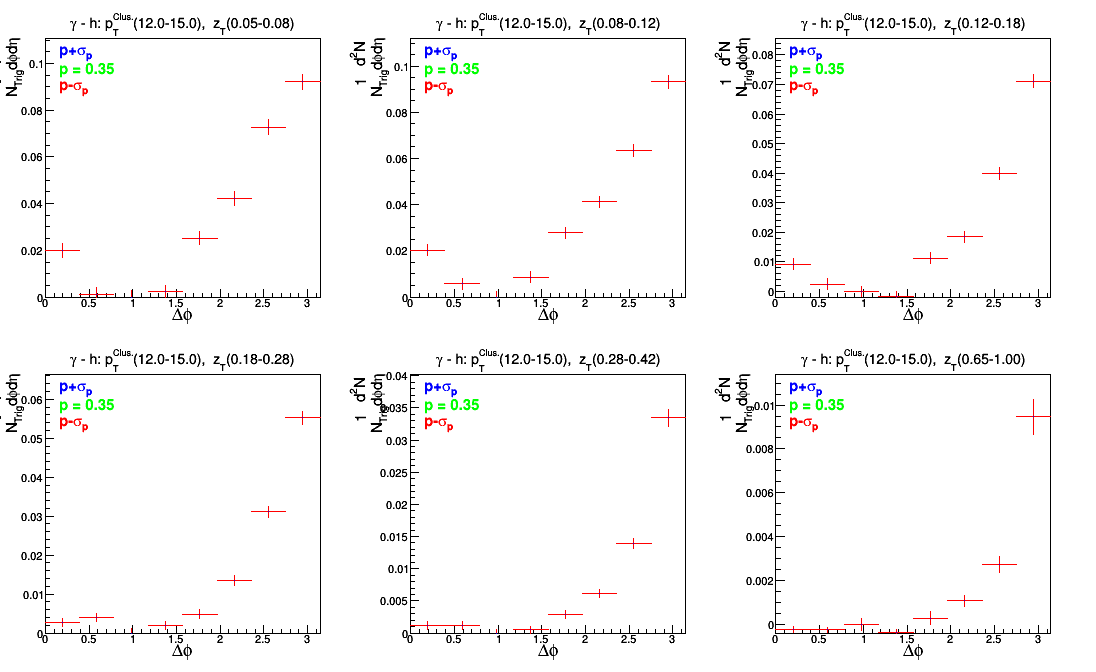

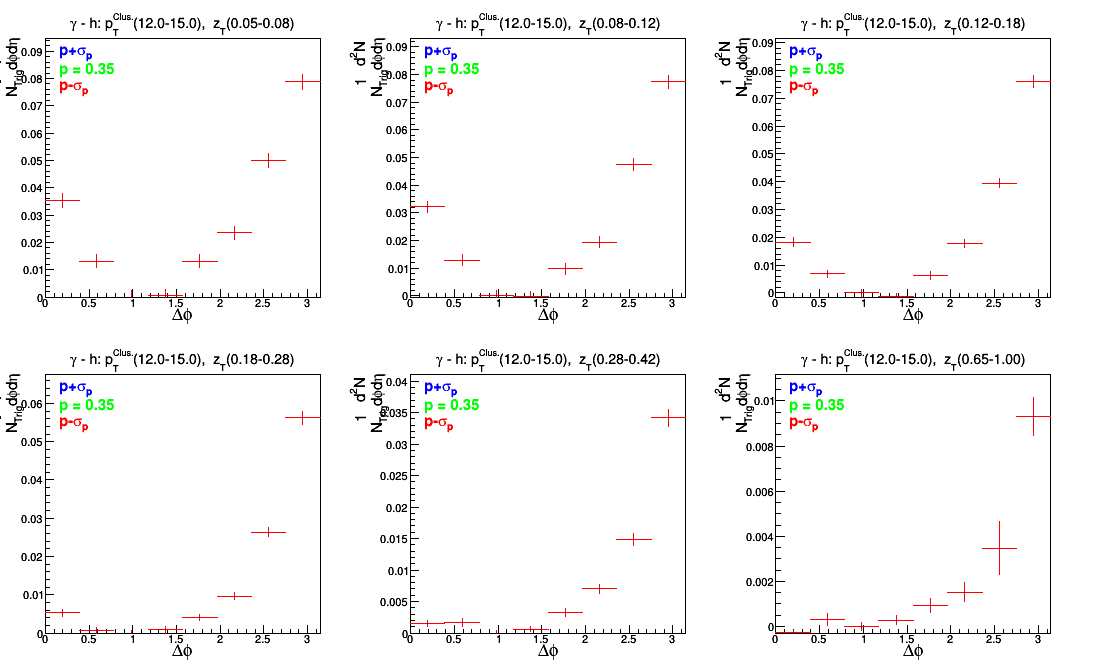

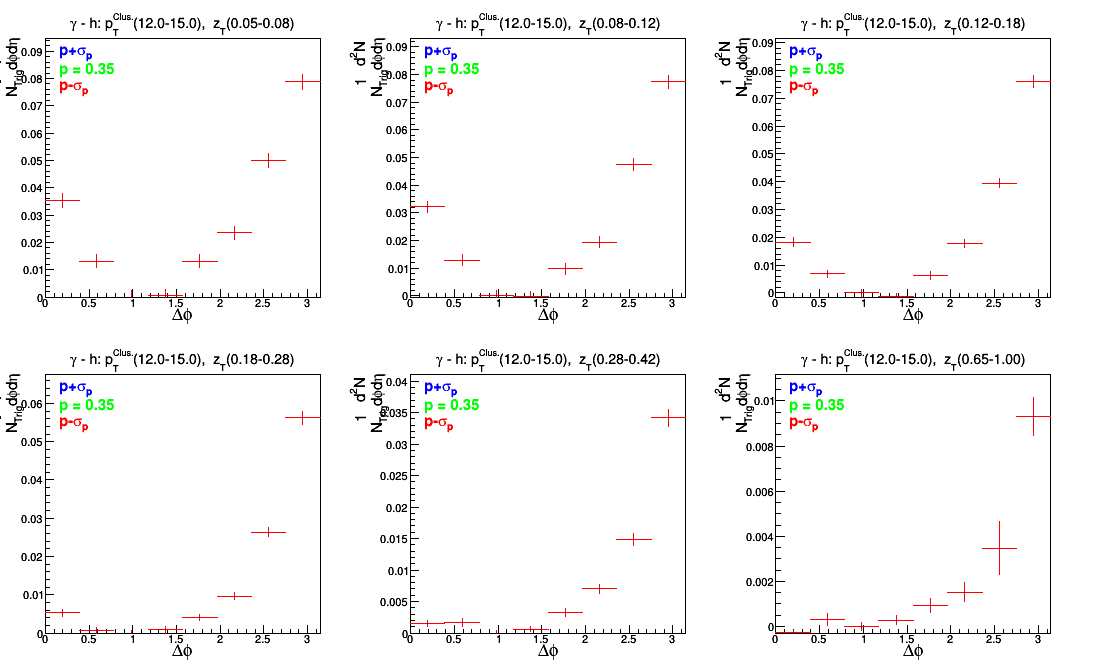

Info in <TCanvas::Print>: pdf file pics/13def_P_sys_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/13def_P_sys_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/pp_P_sys_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/pp_P_sys_Var.pdf has been created


In [1333]:
File1 = 'InputData/13def_SE_GMB_new_Ratio.root'
File1 = pPb_File
prfx1 = '13def'
pPb_FF_P, pPb_P_Error = Get_P_Error(File1,prfx1,0.06,True,True,True)
pPb_FF_P, pPb_P_stat_Error = Get_P_Error(File1,prfx1,0.028,True,True,True)


File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
File2 = pp_File
prfx2 = 'pp'
pp_FF_P, pp_P_Error = Get_P_Error(File2,prfx2,0.06,True,True,True)
pp_FF_P, pp_P_stat_Error = Get_P_Error(File2,prfx2,0.028,True,True,True)

# Calculate Efficiency Uncertainty

In [1334]:
def Get_Eff_Error(filename,prfx,doZYAM=True, doSubtraction=True, DoSys=False):
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    Efficiency = 0.85
    Eff_Err = 0.05
    
    Eff_Error = []
    FF_Eff = []
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,2)

        for ztbin in range(7):
            canvases.cd(ztbin+1)
            Signal_min = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_min = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
            
            Signal_max = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_max = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)

            nbins = Signal.GetSize()-2
        
            #p_error = math.sqrt(0.028**2 + 0.06**2)

            Background_max.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_max.Scale(1/purity[ptbin])
            Signal_max.Add(Background_max,-1)
            Signal_max.Scale(1/(Efficiency+Eff_Err))

            Background_min.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_min.Scale(1/purity[ptbin])
            Signal_min.Add(Background_min,-1) 
            Signal_min.Scale(1/(Efficiency-Eff_Err))

            Background.Scale((1-purity[ptbin])/purity[ptbin])
            Signal.Scale(1/purity[ptbin])
            Signal.Add(Background,-1)
            Signal.Scale(1/Efficiency)
            
            y_min = 1.2*Signal_max.GetMinimum()
            y_max = 1.2*Signal_min.GetMaximum()
            Signal_max.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_max.Draw()
            Signal_min.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_min.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{Eff+#sigma_{eff}}")
            latex.DrawLatex(0.14,0.79, "#color[3]{Eff}")
            latex.DrawLatex(0.14,0.74, "#color[2]{Eff-#sigma_{eff}}")
            

            #Signal.Add(Signal2,-1)
            
            sum_p_error = 0
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal_max.GetBinContent(i)-Signal_min.GetBinContent(i))/2
                sum_min += Signal_min.GetBinContent(i)
                sum_max += Signal_max.GetBinContent(i)

            print abs(delta/sum_phi)
            Eff_Error.append(delta)
            FF_Eff.append(sum_phi)
        canvases.Update()
        canvases.Draw()
        canvases.SaveAs('pics/%s_Eff_Var.pdf'%(prfx))
    return FF_Eff,Eff_Error

0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778


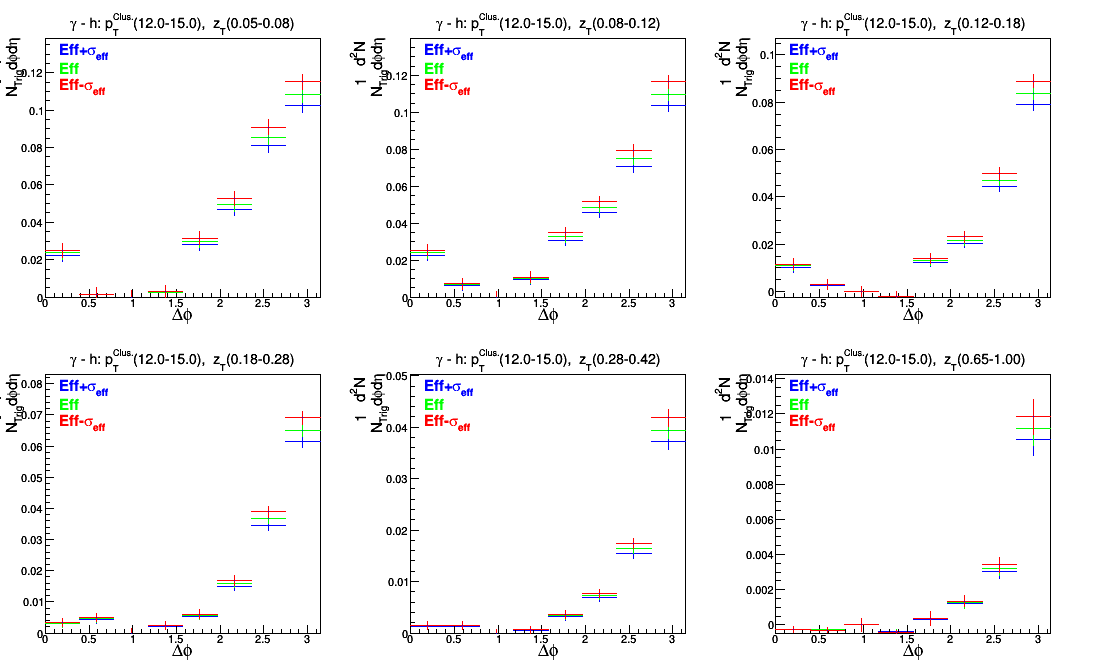

0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778


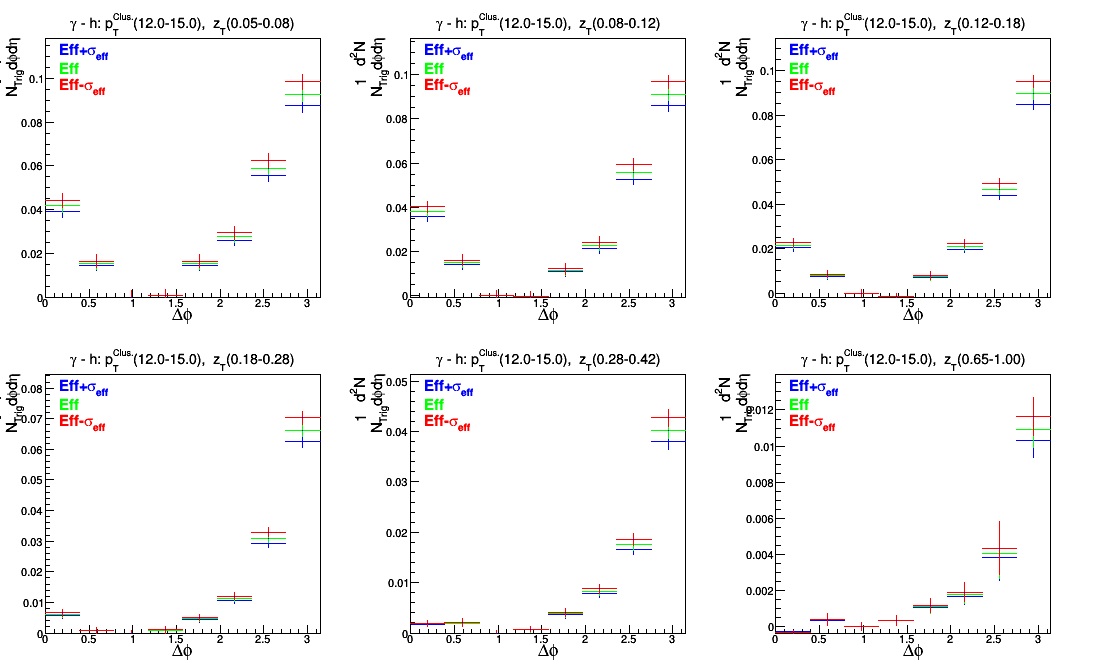

0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778
0.0590277777778


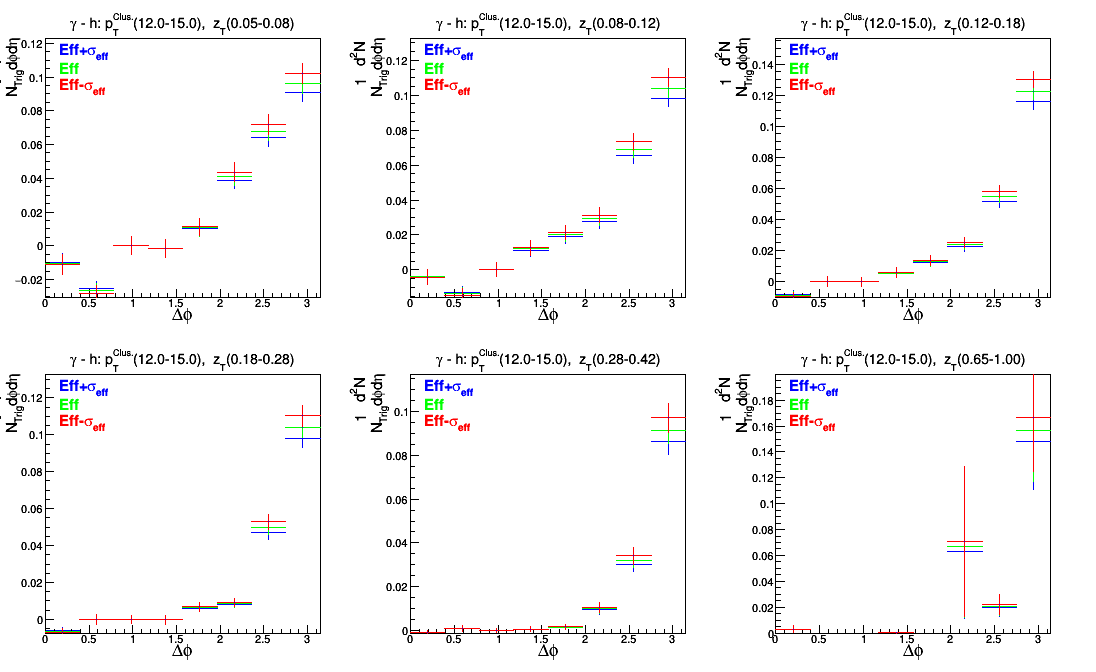

Info in <TCanvas::Print>: pdf file pics/13def_Eff_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/pp_Eff_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/18b10a,_Eff_Var.pdf has been created


In [1335]:
#File2 = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
#File1 = 'InputData/13def_SE_GMB_new_Ratio.root'
File1 = pPb_File
prfx1 = '13def'
pPb_FF_Eff, pPb_Eff_Error = Get_Eff_Error(File1,prfx1,True,True,True)
File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
File2 = pp_File
prfx2 = 'pp'
pp_FF_Eff, pp_Eff_Error = Get_Eff_Error(File2,prfx2,True,True,True)
#MC_FF_Eff, MC_Eff_Error = Get_Eff_Error(MC_File,'18b10a',True,False,False)

MC_FF_Eff, MC_Eff_Error = Get_Eff_Error(MC_File,'18b10a,',True,False,True)

In [1336]:
def Get_Assym_Error(filename,prfx,doZYAM=True, doSubtraction=True, DoSys=False):
    
    File1 = "InputData/13f_SE_Correlation_GMB_Ratio.root"
    File2 = "InputData/13de_4L_SE_Correlation_GMB_Ratio.root"
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    Assym_Error = []
    FF_Assym = []
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,2)

        for ztbin in range(7):
            canvases.cd(ztbin+1)
            Signal_min = GetPhiProj(File1,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_min = GetPhiProj(File1,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
            
            Signal_max = GetPhiProj(File2,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background_max = GetPhiProj(File2,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)

            nbins = Signal.GetSize()-2
        

            Background_max.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_max.Scale(1/purity[ptbin])
            Signal_max.Add(Background_max,-1)
            #Signal_max.Scale(1/(Efficiency+Eff_Err))

            Background_min.Scale((1-purity[ptbin])/purity[ptbin])
            Signal_min.Scale(1/purity[ptbin])
            Signal_min.Add(Background_min,-1) 
            #Signal_min.Scale(1/(Efficiency-Eff_Err))

            Background.Scale((1-purity[ptbin])/purity[ptbin])
            Signal.Scale(1/purity[ptbin])
            Signal.Add(Background,-1)
            #Signal.Scale(1/Efficiency)
            
            #y_min = 1.2*Signal_max.GetMinimum()
            #y_max = 1.2*Signal_min.GetMaximum()
            #Signal_max.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_max.Draw()
            Signal_min.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_min.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{13de}")
            latex.DrawLatex(0.14,0.79, "#color[3]{Eff}")
            latex.DrawLatex(0.14,0.74, "#color[2]{13f}")
            

            #Signal.Add(Signal2,-1)
            
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal.GetBinContent(i)-Signal_max.GetBinContent(i))/2
                sum_min += Signal_min.GetBinContent(i)
                sum_max += Signal_max.GetBinContent(i)

            print abs(delta/sum_phi)
        Assym_Error.append(delta)
        FF_Assym.append(sum_phi)
        canvases.Update()
        canvases.Draw()
        canvases.SaveAs('pics/%s_Assym_Var.pdf'%(prfx))
    return FF_Assym,Assym_Error

In [1337]:
File = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
prfx = '13def'
#File = "InputData/13de_4L_SE_Correlation_GMB_Ratio.root"
#FF_Assym, Eff_Assym = Get_Assym_Error(File,prfx,True,True,True)

# Calculate UE Subtraction Uncertainty

In [1338]:
def Subtract_LE2(PhiProjection,LE_Proj,DoSys=False,doMax=True):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow    

    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4))
    LE_N = LE_max-LE_min+1
    LE = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    LE_Error = 0
    for NError in range(LE_min,LE_max):
        LE_Error += (LE_Proj.GetBinError(NError))**2

    LE_Error = math.sqrt(LE_Error)
    print LE_Error
    LE_Error = LE_Error/(LE_N)
    
    if (doMax):
        print LE_Error
        LE = LE+LE_Error
    else:
        LE = LE-LE_Error
        
    sumerror=0
    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-LE
            PhiProjection.SetBinContent(i,new_y)
            if (DoSys):
                #new_y_error = math.sqrt(LE_Error**2) #Propagate the systematic by itself
                new_y_error =  0
            else:
                new_y_error = 0    
            PhiProjection.SetBinError(i,new_y_error)

    #print math.sqrt(sumerror)

In [1339]:
def Subtract_ZYAM2 (PhiProjection, doMax=True):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow

    #zyam = PhiProjection.Integral(3,4)/2
    Z_min = (PhiProjection.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (PhiProjection.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam = PhiProjection.Integral(Z_min,Z_max)/(Z_N)
    Z_Error = 0
    for nz in range(Z_min,Z_max+1):
        print PhiProjection.GetBinError(nz)
        Z_Error += (PhiProjection.GetBinError(nz))**2
    Z_Error = math.sqrt(Z_Error)
    if (doMax):
        zyam = zyam+Z_Error
    else:
        zyam = zyam-Z_Error
    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-zyam
            PhiProjection.SetBinContent(i,new_y)
            new_y_error = 0
            PhiProjection.SetBinError(i,new_y_error)

In [1340]:
def GetPhiProj2(filename,prfx,ipt, izt, Signal_DNN=True, doZYAM=True,DoSys=False,doMax=True):
    file = ROOT.TFile(filename)

    if (DoSys):
        SysE = "_Stat+Sys"
    else:
        SysE = ""
    
    if (Signal_DNN == "inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f%s' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(1.4))
                                        #10*zTbins[izt+1]),5,11)
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f%s' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1],SysE),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(1.4))
                                        #10*zTbins[izt+1]),5,11)
    
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/2.8) #scale by eta region
    #PhiProjection.SetMarkerStyle(20)
    
    ntriggers = Get_NTriggers(filename,prfx,ipt, Signal_DNN)
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers) #per trigger yield
        
        
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)    
    if(doZYAM):
        LE_Proj,legend = GetLEProj(filename, ipt, izt, Signal_DNN)
        #Subtract_LE2(PhiProjection,LE_Proj,DoSys,doMax)#Stat+Sys Bool (True, False = Just Stat.)
        Subtract_ZYAM2(PhiProjection,doMax)
    
    #file.Close()
    return PhiProjection

In [1341]:
def Get_LE_Error(filename,prfx,doZYAM=True, doSubtraction=True, DoSys=False):
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.05)
    
    
    for ptbin in range(3):
        if (ptbin > 0): continue
        ptbin = ptbin+2
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1100,700)
        canvases.Divide(3,3)

        LE_Error = []
        FF_LE = []
        for ztbin in range(7):
            canvases.cd(ztbin+1)
            Signal_max = GetPhiProj2(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys,True) #High DNN (True) MAX LE
            Background_max = GetPhiProj2(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys,True) #Low DNN (False) MAX LE
            Signal_min = GetPhiProj2(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys,False) #High DNN (True) MIN LE
            Background_min = GetPhiProj2(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys,False) #Low DNN (False) MIN LE

            Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
            Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)

            N1 = Get_NTriggers(filename,prfx,ptbin, True)
            N2 = Get_NTriggers(filename,prfx,ptbin, False)

            LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
            LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)

            LE_Sig = GetLE_Val(LE_Proj_Sig)
            LE_Bkg = GetLE_Val(LE_Proj_Bkg)
            nbins = Signal.GetSize()-2
            if not(filename == MC_File):

                Background_max.Scale((1-purity[ptbin])/purity[ptbin])
                Signal_max.Scale(1/purity[ptbin])
                Signal_max.Add(Background_max,-1)

                Background_min.Scale((1-purity[ptbin])/purity[ptbin])
                Signal_min.Scale(1/purity[ptbin])
                Signal_min.Add(Background_min,-1) 

                Background.Scale((1-purity[ptbin])/purity[ptbin])
                Signal.Scale(1/purity[ptbin])
                Signal.Add(Background,-1)
            
            y_min = 1.2*Signal_max.GetMinimum()
            y_max = 1.2*Signal_min.GetMaximum()
            
            Signal_min.GetYaxis().SetRangeUser(y_min,y_max)
            Signal_min.Draw()
            Signal_min.SetLineColor(2)
            Signal.SetLineColor(3)
            Signal.Draw("same")
            Signal_max.Draw("same")
            
            latex.DrawLatex(0.14,0.85, "#color[4]{LE+#sigma_{LE}}")
            latex.DrawLatex(0.14,0.79, "#color[3]{LE}")
            latex.DrawLatex(0.14,0.74, "#color[2]{LE-#sigma_{LE}}")

            #Signal_min.Add(Signal_max,-1)
            #LE_error = []
            
            sum_phi = 0
            sum_max = 0
            sum_min = 0
            delta = 0
            for i in range (6,nbins+1):
                sum_phi += Signal.GetBinContent(i)
                delta += (Signal_min.GetBinContent(i)-Signal_max.GetBinContent(i))/2
                sum_min += Signal_min.GetBinContent(i)
                sum_max += Signal_max.GetBinContent(i)
            LE_Error.append(delta)
            FF_LE.append(sum_phi)
            print "%1.2f"%(delta/sum_phi * 100)
        canvases.Update()
        canvases.Draw()
        canvases.SaveAs('pics/%s_LE_Var.pdf'%(prfx))
    return FF_LE, LE_Error

0.00417542772909
0.00294234100641
0.00417542772909
0.00294234100641
4.33
0.00332124034346
0.00244040457227
0.00332124034346
0.00244040457227
3.75
0.00241172249429
0.00180384259325
0.00241172249429
0.00180384259325
4.23
0.00151729895101
0.00109110482159
0.00151729895101
0.00109110482159
3.33
0.000970158603842
0.000599396073484
0.000970158603842
0.000599396073484
3.44
0.000295660030167
0.000434335582722
0.000295660030167
0.000434335582722
4.82
0.000202436973748
0.00029068480194
0.000202436973748
0.00029068480194
6.49


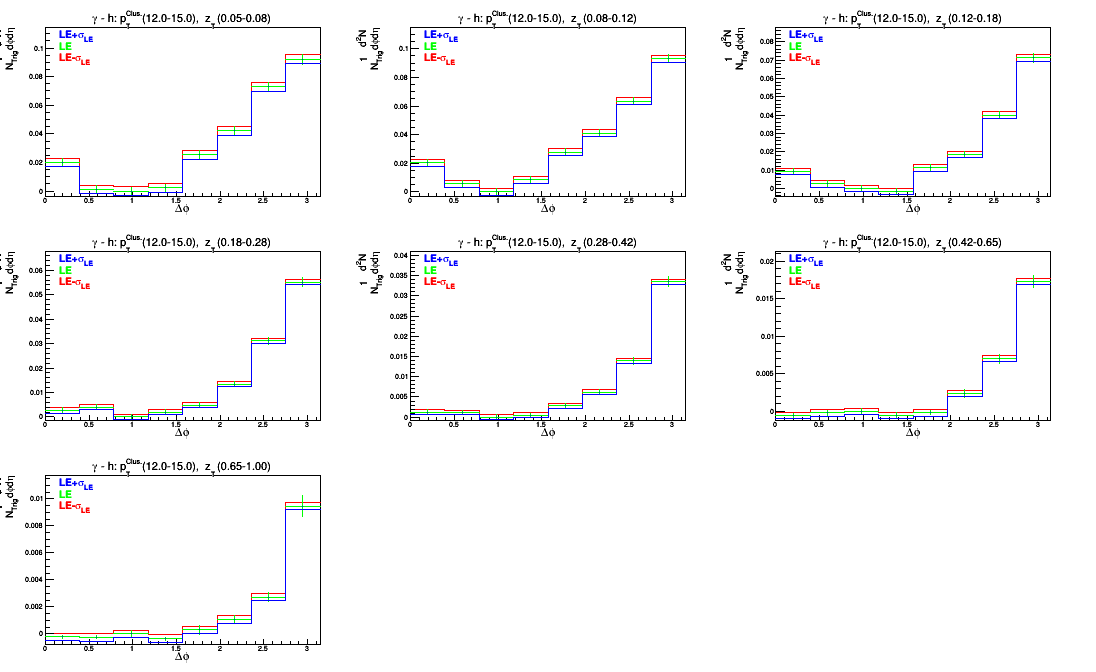

0.00336931009228
0.00232177951576
0.00336931009228
0.00232177951576
4.65
0.00277982688631
0.00196045475776
0.00277982688631
0.00196045475776
4.14
0.00195318909891
0.00142861124483
0.00195318909891
0.00142861124483
3.26
0.00129686178847
0.000816518060317
0.00129686178847
0.000816518060317
2.72
0.000693225396522
0.000472441029345
0.000693225396522
0.000472441029345
2.57
0.000455908863586
0.000383110946986
0.000455908863586
0.000383110946986
3.01
0.000535824872139
0.000192923515183
0.000535824872139
0.000192923515183
4.33


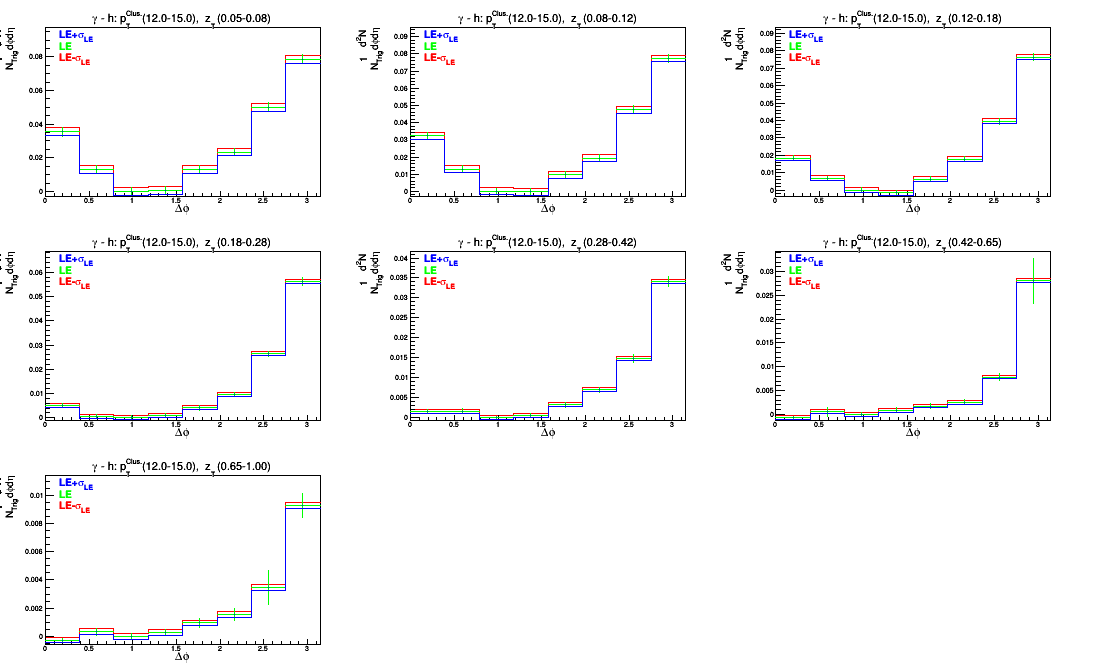

[0.007085514139225157, 0.005975364899881824, 0.004346014750248178, 0.0025046605359983435, 0.0014426520785325698, 0.00115768441838832, 0.0006181091333438363]
0.00530901991886
0.00452951525458
0.00530901991886
0.00452951525458
6.70
0.00368715863886
0.00333827480138
0.00368715863886
0.00333827480138
4.97
0.00289388024158
0.00240680149181
0.00289388024158
0.00240680149181
4.78
0.00131174235384
0.00165504247298
0.00131174235384
0.00165504247298
3.82
0.000652465454321
0.00066555485195
0.000652465454321
0.00066555485195
3.82
0.000270203778585
0.000431508824139
0.000270203778585
0.000431508824139
1.34
0.0
0.0
0.0
0.0
0.00


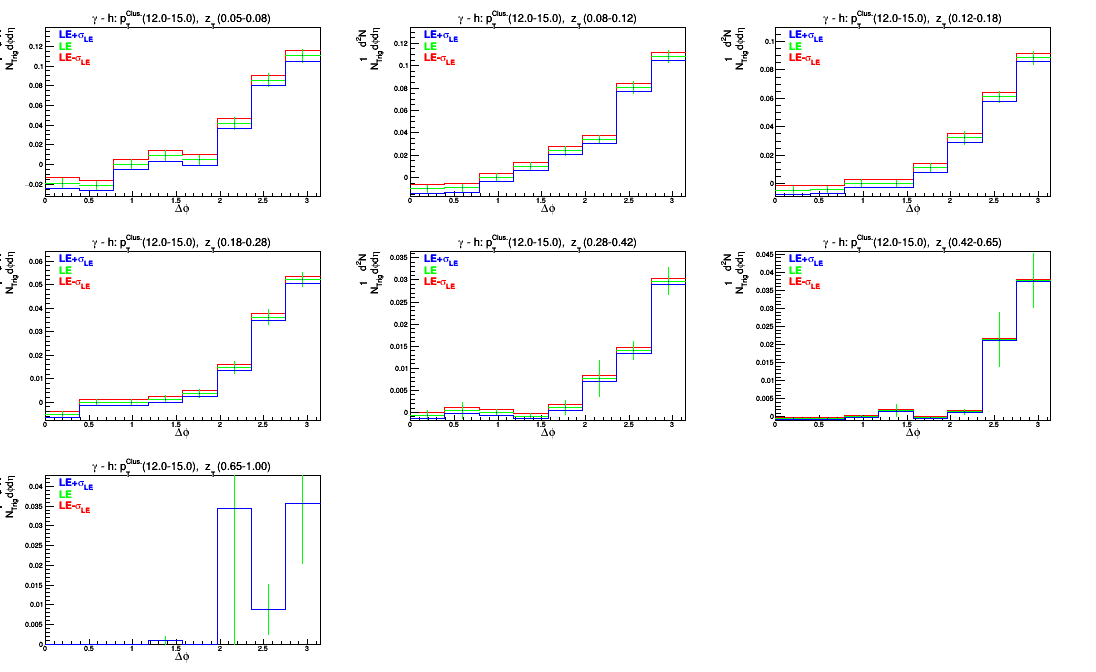

[0.015927059756568884, 0.011061475916569266, 0.008681640724754344, 0.003935227061524831, 0.0019573963629633453, 0.0008106113357555895, 0.0]


Info in <TCanvas::Print>: pdf file pics/13def_LE_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/pp_LE_Var.pdf has been created
Info in <TCanvas::Print>: pdf file pics/18b10a_LE_Var.pdf has been created


In [1342]:
#File1 = 'InputData/13def_SE_GMB_new_Ratio.root'
File1 = pPb_File
prfx1 = '13def'
pPb_LE_Eff, pPb_LE_Error = Get_LE_Error(File1,prfx1,True,True,True)
#File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
File2 = pp_File
prfx2 = 'pp'
pp_LE_Eff, pp_LE_Error = Get_LE_Error(File2,prfx2,True,True,True)
print pp_LE_Error
MC_LE_Eff, MC_LE_Error = Get_LE_Error(MC_File,'18b10a',True,False,True)
print MC_LE_Error


# Summarize Errors

In [1343]:
pp_Systematic = []
for i in range (NzT):
    pp_Systematic.append(math.sqrt(pp_LE_Error[i]**2 + pp_P_Error[i]**2 + pp_P_stat_Error[i]**2 + pp_Eff_Error[i]**2))
print pp_Systematic

pPb_Systematic = []
for i in range (NzT):
    pPb_Systematic.append(math.sqrt(pPb_LE_Error[i]**2 + pPb_P_Error[i]**2 + pPb_P_stat_Error[i]**2 + pPb_Eff_Error[i]**2))
print pPb_Systematic
MC_Systematic = []
for i in range (NzT):
    MC_Systematic.append(math.sqrt(MC_LE_Error[i]**2 + MC_Eff_Error[i]**2))
print MC_Systematic

[0.012727408613309026, 0.011662764639418474, 0.010232996081679052, 0.006874878826948218, 0.004151630769247563, 0.0029095406896192974, 0.0011686310663071458]
[0.016942558059020514, 0.015617458494581824, 0.010537327335443427, 0.007686857375135003, 0.004146501038660384, 0.002256690014199068, 0.0012626628808542653]
[0.020001427753027136, 0.01627411450722874, 0.014695275300873627, 0.010348786580193968, 0.008126411199801974, 0.007437924293689736, 0.014391464266612707]


# Fragmentation

In [1344]:
# zT_point = []
# for ztbin in range (6):
#     zT_point.append(zTbins[ztbin])
# x = np.asarray(zT_point)
# dx = 1
# #x = np.arange(15, step=dx)
# y = np.asarray(FF_LE)
# #y = x*2
# print x
# print y
# ex = 0.015#np.ones(x.shape) * dx
# ey = y*0.15    # e.g. a 15% uncertainty
# matplotlib.pyplot.bar(x, ey, bottom=y-ey/2, width=ex, align='center')
# plt.yscale('log')
# plt.xscale('log')

# Purity Scaling + Subtraction

#### Subtraction: $C_{S} = \frac{C_{SR} - (1-p) C_{BR}}{p}$

In [1345]:
def GetBKGsubtracted(filename,prfx,ptbin, ztbin, doZYAM=True, doSubtraction=True, DoSys=False):
    Signal = GetPhiProj(filename,prefix,ptbin,ztbin,True,doZYAM,DoSys) #High DNN (True)
    Background = GetPhiProj(filename,prefix,ptbin,ztbin,False,doZYAM,DoSys) #Low DNN (False)
    N1 = Get_NTriggers(filename,prfx,ptbin, True)
    N2 = Get_NTriggers(filename,prfx,ptbin, False)
    
    LE_Proj_Sig,legend = GetLEProj(filename, ptbin, ztbin, True)
    LE_Proj_Bkg,legend_bkg = GetLEProj(filename, ptbin, ztbin, False)
    
    LE_Sig = GetLE_Val(LE_Proj_Sig)
    LE_Bkg = GetLE_Val(LE_Proj_Bkg)
    
    nbins = Signal.GetSize()-2
    p_error = math.sqrt(0.028**2 + 0.06**2)

    if (prfx == "pp"):
        Systematic = pp_Systematic 
    if (prfx == '13def'):
        Systematic = pPb_Systematic
    if (doSubtraction):
        
        if (DoSys):
            #print "GetBkgSubtracted"    
            for i in range(nbins+1):
                y_s = Signal.GetBinContent(i)
                y_s_new = y_s*(1/purity[ptbin])
                y_s_error = Signal.GetBinError(i) 
                
                ##FIXME!!!!
                # Need to use the variation method below, but instead take the variation bin by bin (look at one sigma changes)
                #
                
                #y_s_new_error = (abs(y_s_new)Cmath.sqrt(P_Error[ztbin]/FF_P[ztbin]))
                y_s_new_error = Systematic[ztbin]
                #(abs(y_s_new))*math.sqrt((y_s_error/y_s)**2 + (p_error/purity[ptbin])**2)# + (0.06 / 0.75)**2)
                #need add sys, pp_LE_Error
                #need box for efficiency, purity_sys, purity_stat, LE
        
                Signal.SetBinError(i,y_s_new_error)
                Signal.SetBinContent(i,y_s_new)
                
                y_b = Background.GetBinContent(i)
                y_b_new = y_b*((1-purity[ptbin])/purity[ptbin])
                y_b_error = Background.GetBinError(i) #JUST UE Error
                y_b_new_error = (abs(y_b_new))*math.sqrt((y_b_error/y_b)**2 + (p_error/purity[ptbin])**2)# + (0.06 / 0.75)**2)
                
                Background.SetBinError(i,y_b_new_error)
                Background.SetBinContent(i,y_b_new)
                
                Signal.SetBinContent(i,(y_s_new-y_b_new))
                Signal.SetBinError(i,math.sqrt(y_s_new_error**2 + y_b_new_error**2))
                #print Signal.GetBinContent(i)," +/- ",Signal.GetBinError(i)
                #print "Phi Bin: ",i,"Signal: ",Signal.GetBinContent(i),"purity: ",p_error/purity[ptbin]," LE Error:",(y_s_error/y_s)," Total: ",100*math.sqrt((y_s_error/y_s)**2 + (p_error/purity[ptbin])**2),"%"
                #print Signal.GetBinError(i)/Signal.GetBinContent(1),"%"
        else:
            Background.Scale(1-purity[ptbin])
            Signal.Add(Background,-1)
            Signal.Scale(1/purity[ptbin])
            Background.Scale(1/purity[ptbin])
    #print "\n"
    Signal.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    Background.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    return Signal,Background,N1
    #return Background,Signal,N1

# Loop and Plot

In [1346]:
def Looping(filename,DoZYAM,DoSub=True,DoSys=True):
    canvases = []
    subtracts = []
    #newfile = ROOT.TFile("%s_subtracted_correlation.root"%(prefix),"RECREATE")
    #ROOT.gDirectory.pwd()
   
    #File2 = 'InputData/13def_SE_GMB_Ratio.root'
    #File2 = 'InputData/13def_4L_SE_L0_Correlation_GMB_Ratio.root'
    #File2 = 'InputData/13def_SE_GMB_new_Ratio.root'
    File2 = pPb_File
    prfx2 = '13def'
    
    #File2 = 'InputData/17q_SE_Correlation_GMB_Ratio.root'
    #File2 = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
    #File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
    #prfx2 = 'pp'
    
    #File3 = 'InputData/18b10a_calo_pthat1to2_SE_Correlation_GMB_Ratio.root'
    #File3 = 'InputData/18b10a_calo_pthat1to2_SE_Correlation.root'
    File3 = 'InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root'
    prfx3 = "18b10a"

    hstack = []
    if (prfx2 == "13def"):
        Systematic = pPb_Systematic
        ymins = [-1.5,-2,-4,-10,-3.5,-3.5,-3.5]
        ymaxs = [6,5,]
    if (prfx2 == "pp"):
        ymins = [-3,-4,-3,-3,-3.5,-2,-2]
        Systematic = pp_Systematic

    for ptbin in range(3):
        canvases.append(ROOT.TCanvas("canv%i"%(ptbin),"canv",3000,2000))
        canvases[ptbin].Divide(3,3)
        if (ptbin > 0): continue;
        ptbin = ptbin+2
        for ztbin in range(7):
            
            hstack.append(ROOT.THStack("hs_%i"%(ztbin),"#gamma-hadron: p_{T}^{Clus.}(%1.0f-%1.0f) z_{T}(%1.2f-%1.2f)"
                                             %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1])))
            
            hsig3 = GetPhiProj(File3,prfx3,ptbin,ztbin,True,True,False) #[DNN],[Subtraction Bool][DoSys]
            #hsig3,hbkg3,NTrig3 = GetBKGsubtracted(File3,prfx3,ptbin,ztbin,DoZYAM,False,True)
            hsig3.SetFillColorAlpha(4,0.15)
            
            hsig,hbkg,NTrig = GetBKGsubtracted(File2,prfx2,ptbin,ztbin,DoZYAM,DoSub,False)#doZYAM,doSubtraction
            hsig_sys,hbkg_sys,NTrig_sys = GetBKGsubtracted(File2,prfx2,ptbin,ztbin,DoZYAM,DoSub,DoSys)
            
            #Scale by Efficiency
            hsig.Scale(1/0.85)
            hsig_sys.Scale(1/0.85)
            hsig_sys.SetFillStyle(0);
            hsig_sys.SetLineColor(ROOT.kBlack);
            hsig_sys.SetLineWidth(3);
            #hsig_sys.Draw("E2");

            canvases[ptbin-2].cd(ztbin+1)
            ROOT.gPad.SetLeftMargin(0.18)
            ROOT.gPad.SetRightMargin(0.0)
            
            ymin = ymins[ztbin]*abs(min(hsig.GetMinimum(),hbkg.GetMinimum()))
           
#           if (ztbin == 1):
#                 print
#                 ymax = 0.5*max(hsig.GetMaximum(),hbkg.GetMaximum())
#             else:
#                 ymax = 0.6*max(hsig.GetMaximum(),hbkg.GetMaximum())
#             hsig_sys.GetYaxis().SetRangeUser(ymin,ymax)
#             hbkg_sys.GetYaxis().SetRangeUser(ymin,ymax)
            
            if not(DoSub):
                ymax = 1.5*max(hsig.GetMaximum(),hbkg.GetMaximum())
                ymin = -1.5*abs(min(hsig.GetMinimum(),hbkg.GetMinimum()))
                #hbkg.Scale(1/0.85)
                #hbkg_sys.Scale(1/0.85)
                hsig_sys.GetYaxis().SetRangeUser(ymin,ymax)
                hbkg_sys.GetYaxis().SetRangeUser(ymin,ymax)
                hstack[ztbin].Add(hsig)
                
                hstack[ztbin].Add(hsig_sys)
                hstack[ztbin].Add(hbkg)
                hstack[ztbin].Add(hbkg_sys)
                
            else:
                #hsig_sys.GetYaxis().SetRangeUser(-1.8*abs(hsig_sys.GetMinimum()),1.8*hsig_sys.GetMaximum())
                
                hsig_sys.SetLineColor(1)
                hsig3.SetFillColorAlpha(3,0.2)
                
            
                if (DoSys):
                    hsig_sys.SetFillColor(18)
                    hsig_sys.GetYaxis().SetRangeUser(-3*abs(hsig_sys.GetMinimum()),hsig_sys.GetMaximum()*1.3)
                    hsig_sys.SetLineWidth(1)
                    hstack[ztbin].Add(hsig_sys,"E2")
                    nbins = hsig_sys.GetSize()-1
                    for i in range (1,nbins):
                        hsig_sys.SetBinError(i,Systematic[ztbin])
                    #hsig_sys.Draw("sameE2")
                    #hstack[ztbin].Add(hsig3,"E3")
                    
            hsig.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
            hstack[ztbin].Add(hsig)
            hstack[ztbin].Draw("nostack")
            hstack[ztbin].GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
            hstack[ztbin].GetYaxis().SetTitleSize(0.05)
            hstack[ztbin].GetYaxis().SetTitleOffset(1.5)
            hstack[ztbin].GetXaxis().SetTitle("#Delta#phi")
            hstack[ztbin].GetXaxis().CenterTitle(1)
            hstack[ztbin].GetXaxis().SetTitleOffset(0.6)
            hstack[ztbin].GetXaxis().SetTitleSize(0.06)
            #hsig.Draw("same")
            
            #hsig3.Draw("sameE3")
            
            latex = TLatex()
            latex.SetNDC()
            latex.SetTextSize(0.04)
            #latex.DrawLatex(0.22,0.81,"#color[3]{pp pythia gamma-jet}")
            
            #Overlay
            if not(DoSub):
                DrawLabel(NTrig,ptbin)
                hbkg.Draw("same")
                canvases[ptbin-2].Update()
                legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
                legend.AddEntry(hsig, "0.55 < DNN < 0.85","p")
                legend.AddEntry(hbkg, "0.0 < DNN < 0.3","p")
                #SetOwnership(legend, 0) # 0 = release (not keep), 1 = keep
                #legend.Draw("same")
                DrawLabel3(NTrig,DoSub)
                
                #show unscaled
                #Bkgd = GetPhiProj(filename,ptbin,ztbin,False,DoZYAM)
                #Bkgd.SetMarkerStyle(21)
                #Bkgd.Draw("same")
        
            else:     
                #draw line at 0
                zero_line = ROOT.TLine(0,0,math.pi,0)
                zero_line.SetLineColorAlpha(2, 0.9)
                zero_line.SetLineWidth(2)
                SetOwnership(zero_line, 0)
                zero_line.Draw("same")
                #DrawLabel3(NTrig,DoSub)
                #ROOT.gDirectory = newfile.GetDirectory()
                #hsig.SetDirectory(newfile)
                #hsig.GetCurrentFile().Write()
                #ROOT.gFile = newfile
                #ROOT.gDirectory = newfile
                #ROOT.gDirectory.pwd()
                #newfile.cd()
                #hsig.Write()
                if (prfx2 == "pp"):
                    latex.DrawLatex(0.22,0.85,"#color[4]{pp After Subtraction}")
                if (prfx2 == "13def"):
                    latex.DrawLatex(0.22,0.85,"#color[4]{p+Pb After Subtraction}")
            #TPave
            
        canvases[ptbin-2].Draw()
  
        if (DoSub): 
            canvases[ptbin-2].SaveAs('pics/%s_Subtracted.pdf'%(prfx2))
            #canvases[ptbin-2].SaveAs('pics/%s_Subtracted.png'%(prefix))
        else: 
            canvases[ptbin-2].SaveAs('pics/%s_correlations_Overlay.pdf'%(prfx2))
    #newfile.Close()
    return canvases

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canv0


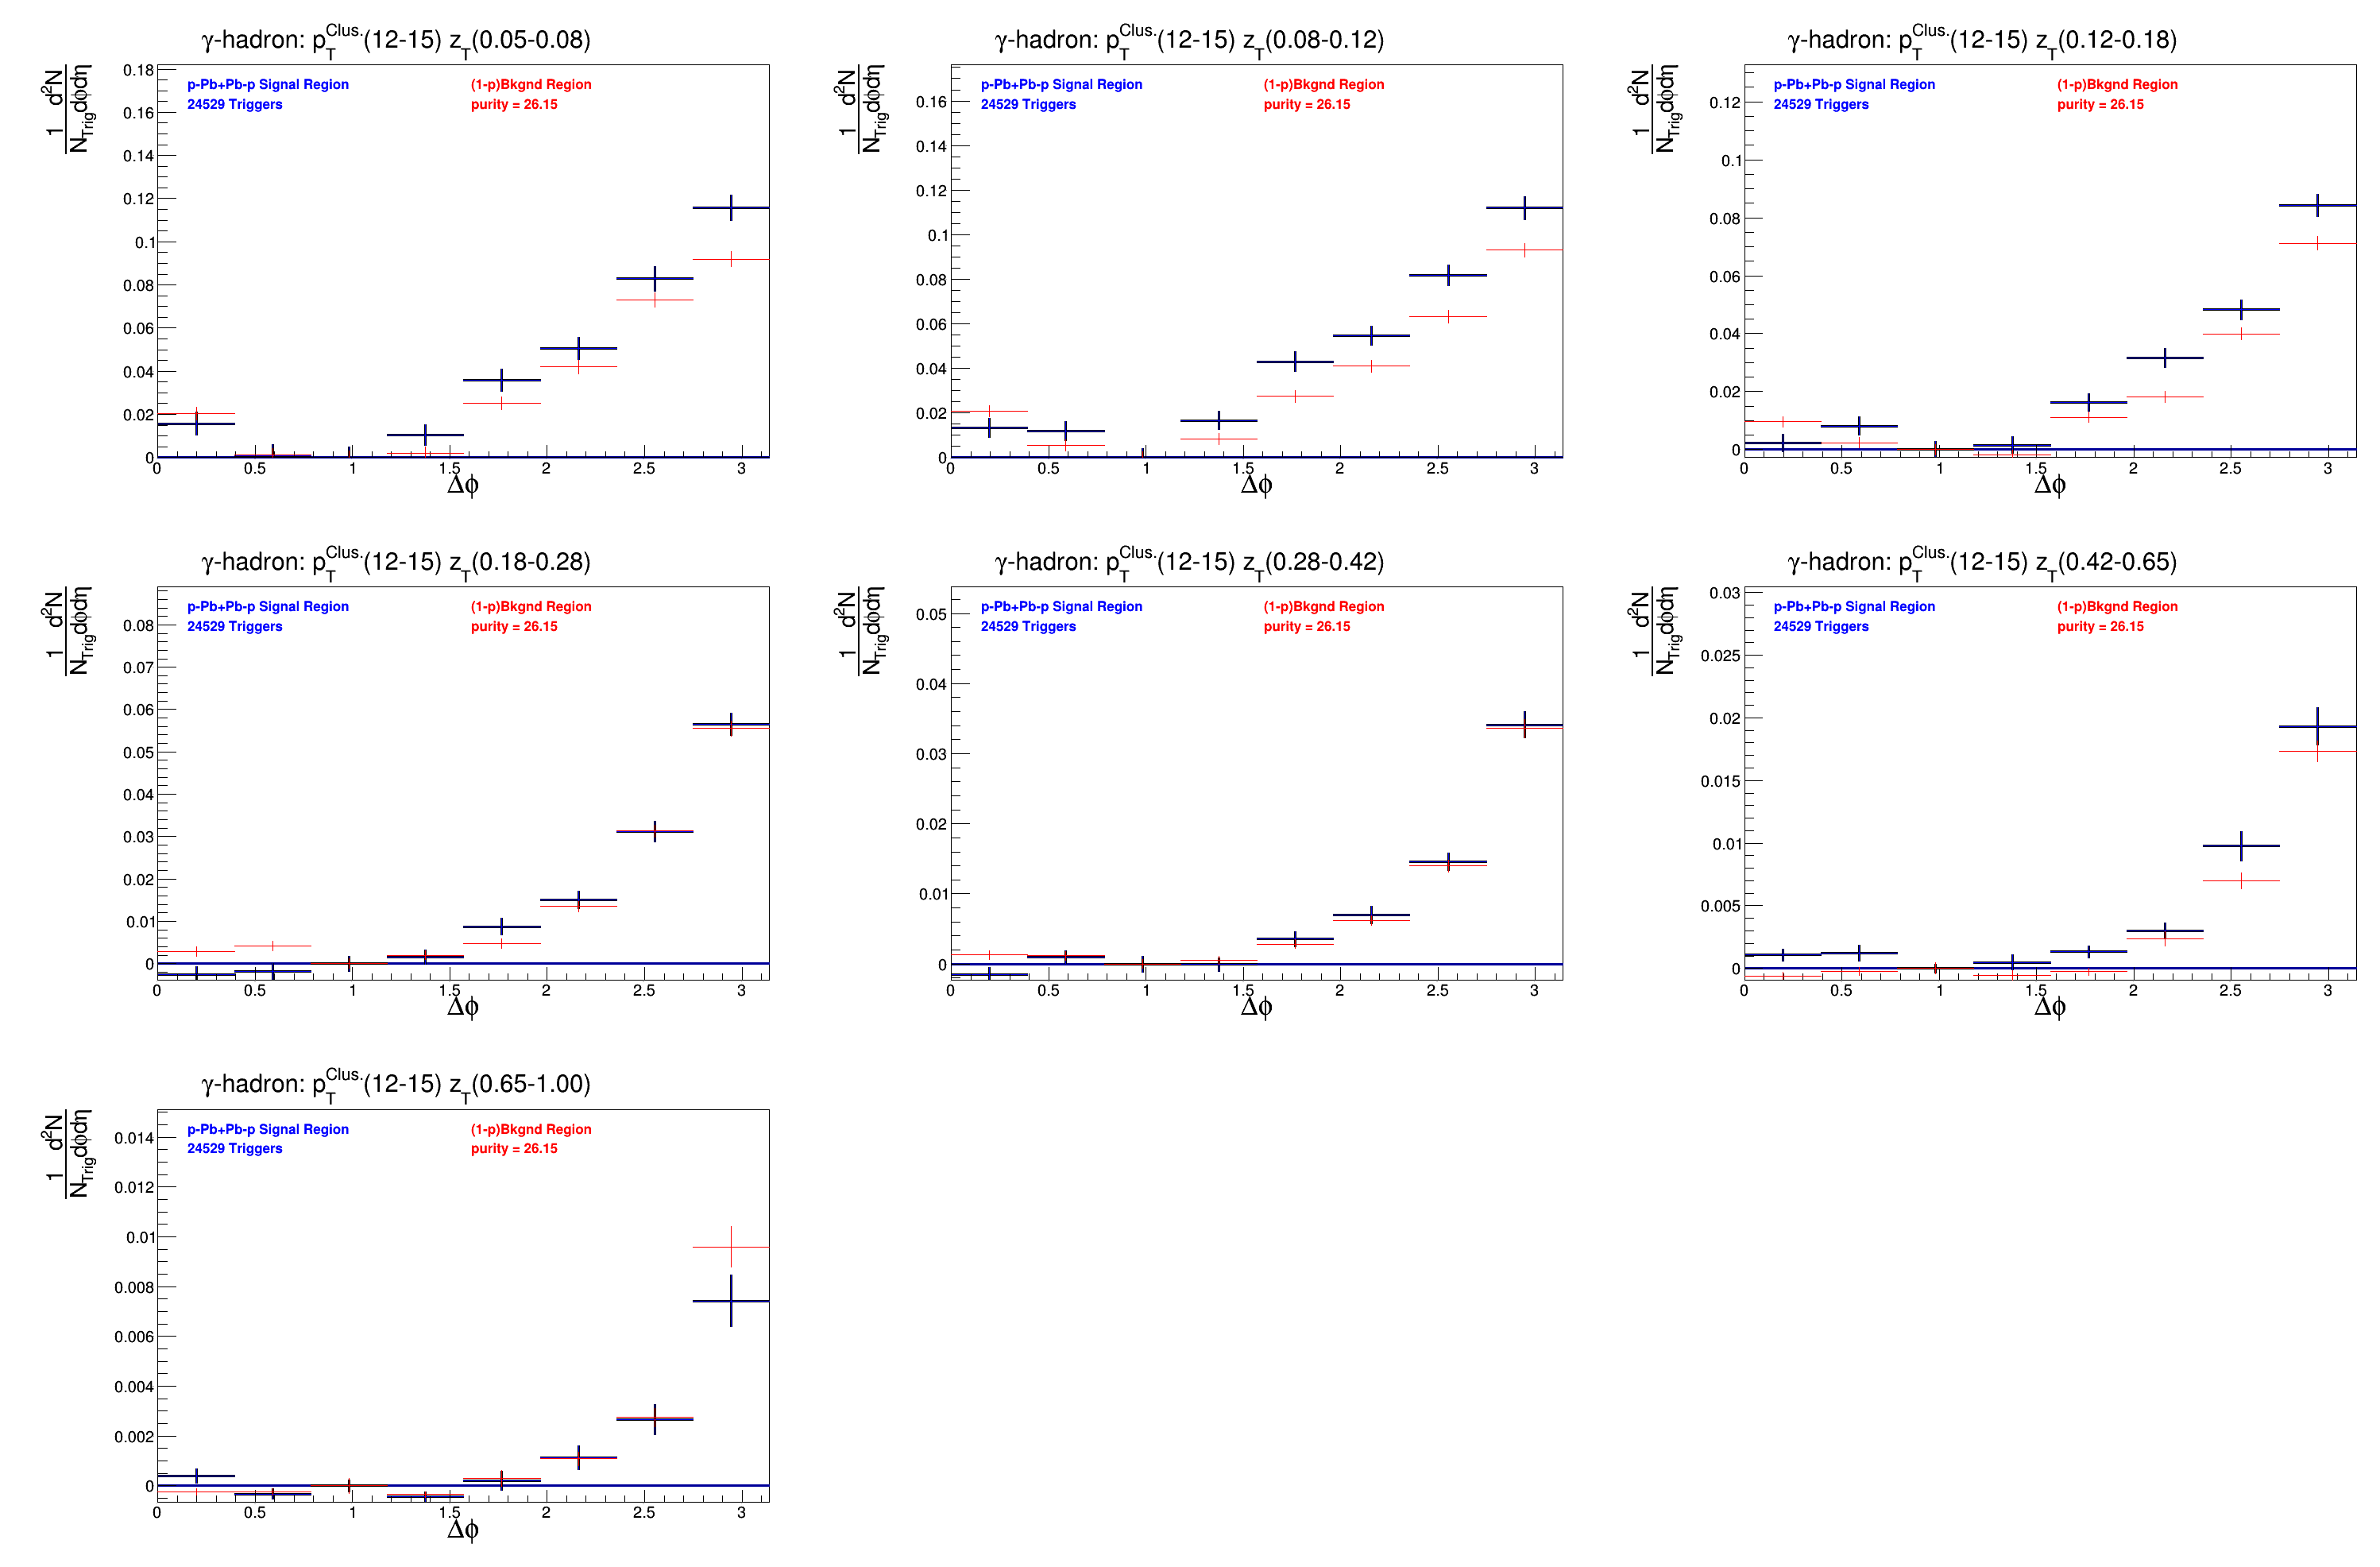

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canv1
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canv2


[<ROOT.TCanvas object ("canv0") at 0x12b74a60>,
 <ROOT.TCanvas object ("canv1") at 0x13cab730>,
 <ROOT.TCanvas object ("canv2") at 0x10bc0410>]

Info in <TCanvas::Print>: pdf file pics/13def_correlations_Overlay.pdf has been created


In [1347]:
Looping(MC_File,True,False,False)#Filename,DoZYAM,DoSub,!DoSys

# Fragmentation Function

In [1348]:
def FF(File,prfx,DoSysB=False):
    zT_integral = []
    zT_point = []
    zT_error = []
    
    Sys_TypeA = []
    Sys_TypeB = []
    for izt in range (7):
        if (prfx == 'pp'):
            Sys_TypeA.append(math.sqrt(pp_P_stat_Error[izt]**2 + pp_LE_Error[izt]**2))
            Sys_TypeB.append(math.sqrt(pp_P_Error[izt]**2 + pp_Eff_Error[izt]**2))
        elif (prfx == '13def'):
            Sys_TypeA.append(math.sqrt(pPb_P_stat_Error[izt]**2 + pPb_LE_Error[izt]**2))
            Sys_TypeB.append(math.sqrt(pPb_P_Error[izt]**2 + pPb_Eff_Error[izt]**2))
        if (prfx == '18b10a'):
            Sys_TypeA.append(math.sqrt(MC_LE_Error[izt]**2 + MC_Eff_Error[izt]**2))
            Sys_TypeB.append(0)
    
    for ptbin in range(3):
        if (ptbin > 0): continue;
        ptbin = ptbin+2
        
        for ztbin in range(7):
            if (prfx == '18b10a'):
                #hsig,hbkg,NTrig = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,False,False)#doZYAM,doSubtraction,dosys 
                hsig = GetPhiProj(File,prfx,ptbin,ztbin,True,True,False)
            else:
                hsig,hbkg,NTrig = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,True,False)#doZYAM,doSubtraction,dosys 
                hsig_sys,hbkg_sys,NTrig_sys = GetBKGsubtracted(File,prfx,ptbin,ztbin,True,True,False)
            Phi_bin_min = hsig.GetXaxis().FindBin(2*math.pi/3)
            Phi_bin_max = hsig.GetXaxis().FindBin(math.pi)
            #zT_point.append((zTbins[ztbin]+zTbins[ztbin+1])/2)
            zT_width = zTbins[ztbin+1]-zTbins[ztbin]
            temp_int = hsig.Integral(hsig.GetXaxis().FindBin(2*math.pi/3),hsig.GetXaxis().FindBin(math.pi))
            
            #temp_int = hsig.Integral(hsig.GetXaxis().FindBin(math.pi/2),hsig.GetXaxis().FindBin(math.pi))
            #print temp_int
            temp_int = temp_int/zT_width
            temp_int = temp_int*Corrections[ztbin]
            zT_integral.append(temp_int)
            #zT_integral.append(hsig.Integral(hsig.GetXaxis().FindBin(2*math.pi/3),hsig.GetXaxis().FindBin(math.pi)))
            #if (prfx == '18b10a'):
                #print temp_int
            #zT_integral.append(hsig.Integral((hsig.GetXaxis().FindBin(1.5)),hsig.GetXaxis().FindBin(math.pi)))
            
            #errors
            zt_tmp_e = 0.0
            if not(DoSysB):
                for phibin in range(Phi_bin_min+1, Phi_bin_max):
                    zt_tmp_e += (hsig.GetBinError(phibin))**2
                zt_tmp_e = math.sqrt(zt_tmp_e)
                zt_tmp_e = math.sqrt(zt_tmp_e**2+Sys_TypeA[ztbin]**2)/zT_width

            else:
                zt_tmp_e = Sys_TypeB[ztbin]/zT_width
                
            zT_error.append(zt_tmp_e)
                
            
            #print prfx,": ",zT_integral[ztbin],"+/-",zT_error[ztbin]
            #print "Relative UE",1/(zT_integral[ztbin]/zT_error[ztbin])
            #print zT_error[ztbin]/zT_integral[ztbin]
            
    #print zT_error
#     plt.plot(zT_point,zT_integral,'bo')
#     plt.errorbar(zT_point, zT_integral, yerr=zT_error, fmt='s')
#     plt.yscale('log')
#     plt.xscale('log')
#     plt.xlabel('${z_T}$',fontsize=20)
#     plt.title('%s: Integrated $\gamma$-Hadron $2\pi/3 < \Delta\phi < \pi$ '%(prfx))
#     plt.gcf()
#     plt.savefig("pics/%s_FFunction.pdf"%(prfx), bbox_inches='tight')
    #figure.show()
    #plt.figure(num=None, figsize=(12, 8), dpi=100).savefig("pics/%s_FFunction.pdf"%(prefix), bbox_inches='tight')
    #print " "
    return zT_integral,zT_error

In [1349]:
#File2 = 'InputData/17q_0GeVTrack_paired_SE_L0_Correlation_GMB_Ratio.root'
#File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
File2 = pp_File
#RootFile = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
prfx2 = 'pp'
#FF(RootFile,"13def")
#FF(File2,prfx2)
FF(MC_File,prefix)

([6.52374870923721,
  4.224825281516858,
  2.6674626525073606,
  1.3864677382198105,
  0.7232242902354349,
  0.3893818954191978,
  0.38094652003917584],
 [0.4194742918336352,
  0.22792776200636944,
  0.12166977199890916,
  0.06620982053562628,
  0.04307241793331335,
  0.049289314459611266,
  0.0973325122957611])

In [1350]:
#np.geomspace(0.05,1,8)

# Loop All FF

hi
[0.8265338361885647, 0.43683569600045524, 0.251675354138968, 0.11604766161532121, 0.060336282841540675, 0.056901328965444975, 0.06268579295769283]
[0.063353185, 0.097191855, 0.14910469, 0.228745595, 0.35092488499999996, 0.53836348, 0.82591817]
[0.013353184999999997, 0.020485485000000005, 0.03142735, 0.04821355499999999, 0.073965735, 0.11347286000000001, 0.17408183]
[8.90105203310725, 5.47577766218284, 2.8393572227943205, 1.0367855121290994, 0.32658597111695364, 0.22155570861656365, 0.14492668775823372]


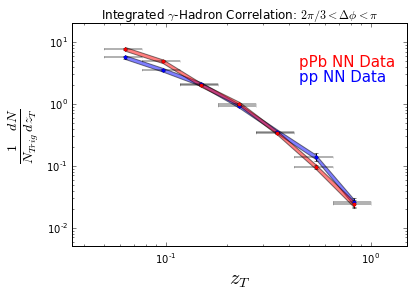

In [1351]:
MC_int, MC_error = FF(MC_File,'18b10a',False)
MC_int,MC_LE_error = FF(MC_File,'18b10a',True)
print "hi"
print MC_error
zT_point = []
zT_width = []
for ztbin in range(NzT):
    zT_point.append((zTbins[ztbin]+ zTbins[ztbin+1])/2)
    zT_width.append((zTbins[ztbin+1]-zTbins[ztbin])/2)
    MC_error[ztbin] = math.sqrt(MC_error[ztbin]**2 + MC_LE_error[ztbin]**2)
print zT_point
print zT_width
#pp NN
#pp_int, pp_error = FF('InputData/17q_SE_NN_Correlation_GMB_Ratio.root','pp',False)
#pp_int_sys, pp_error_sys = FF('InputData/17q_SE_NN_Correlation_GMB_Ratio.root','pp',True)

#Lambda
#pp_int, pp_error = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','13def',False)
#pp_int_sys, pp_error_sys = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','13def',True)

pp_int,pp_error = FF(pp_File,"pp",False)
pp_int_sys, pp_error_sys = FF(pp_File,"pp",True)

#pp_int, pp_error = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','pp',False)
#pp_int_sys, pp_error_sys = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','pp',True)


#pPb NN
# pPb_int, pPb_error = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',False)
# pPb_int_sys, pPb_error_sys = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',True)

pPb_int, pPb_error = FF(pPb_File,'13def',False)
pPb_int_sys, pPb_error_sys = FF(pPb_File,'13def',True)
#print pp_int

#MC_int, MC_error = FF(MC_File,'18b10a',False)
#MC_int,MC_LE_error = FF(MC_File,'18b10a',True)
#MC_error = math.sqrt(MC_error[ztbin]**2 + MC_LE_error[ztbin]**2)

print MC_int
#HARDCODED DUE TO VERY SLIGHTLY DIFFERENT TREATMENT OF UE in MC (NO SIGNAL/BACKGROUND AVERAGE), NEED TO IMPLEMENT FLAG
#MC_int = [11.310060491732425, 7.218237175683422, 3.3433128788925974, 1.493177381233851, 0.4219207415978905, 0.21746230788120627,0.14140750410259098]
#MC_int = [10.144789996230653, 7.015105856903631, 3.515205460316105, 1.3819702542411194, 0.34675022023361635, 0.22417399972941549]
#MC_int, MC_error = FF('InputData/18b10a_calo_pthat1to2_SE_Correlation.root', '18b10a')
#MC_int, MC_error = FF('InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root', '18b10a')
%matplotlib inline
plt.errorbar(zT_point, pp_int, yerr=pp_error, fmt='k.',capsize=2)
plt.errorbar(zT_point, pp_int,xerr=zT_width,linewidth=2, fmt='k.', alpha = 0.3,capsize=1)
plt.fill_between(zT_point, np.asarray(pp_int)-np.asarray(pp_error_sys), np.asarray(pp_int)+np.asarray(pp_error_sys),interpolate=False, alpha=0.5,facecolor='blue')
plt.errorbar(zT_point, pp_int,yerr=pp_error_sys, ecolor='b',fmt='b.',capsize=0)
#plt.fill_betweenx(pp_int,np.asarray(zT_point)-np.asarray(zT_width),np.asarray(zT_point)+np.asarray(zT_width), alpha=0.5)

plt.errorbar(zT_point, pPb_int, yerr=pPb_error, fmt='k.',capsize=2)
plt.errorbar(zT_point, pPb_int,xerr=zT_width,linewidth=2, fmt='k.',alpha = 0.3,capsize=1)
plt.errorbar(zT_point, pPb_int,yerr=pPb_error_sys, ecolor='r',fmt='r.',capsize=0)
plt.fill_between(zT_point, np.asarray(pPb_int)-np.asarray(pPb_error_sys), np.asarray(pPb_int)+np.asarray(pPb_error_sys),interpolate=False, alpha=0.5,facecolor='red')
#plt.fill_between(zT_point, np.asarray(MC_int)-np.asarray(MC_error), np.asarray(MC_int)+np.asarray(MC_error),interpolate=False, alpha=0.5,facecolor='cyan')
#plt.plot(zT_point,MC_int,'co')
#plt.errorbar(zT_point, MC_int, yerr=pp_error, fmt='cs')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r"$\frac{1}{N_{Trig}}\frac{dN}{dz_{T}}$",fontsize=20)
plt.xlabel('${z_T}$',fontsize=20)
plt.xlim(xmin = 0.035,xmax=1.5)
plt.ylim(ymin = 0.005,ymax=20)
#plt.figtext(0.65,0.81,"pythia $\gamma$-j",color='Cyan', fontsize=15)
#plt.figtext(0.65,0.751,"pPb $\lambda_{0}^{2}$ Data",color='Red', fontsize=15)
plt.figtext(0.65,0.751,"pPb NN Data",color='Red', fontsize=15)
plt.figtext(0.65,0.7,"pp NN Data",color='Blue', fontsize=15)
#plt.figtext(0.65,0.64,"pythia $\gamma$-j pp",color='Cyan', fontsize=15)
plt.title('Integrated $\gamma$-Hadron Correlation: $2\pi/3 < \Delta\phi < \pi$ ')
#plt.figure.set_size_inches(18.5, 10.5)
#plt.figure(num=None, figsize=(12, 10), dpi=180, facecolor='w', edgecolor='k')
plt.gcf()
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()


In [1352]:
#     #pp NN
# #pp_int, pp_error = FF('InputData/17q_SE_NN_Correlation_GMB_Ratio.root','pp',False)
# #pp_int_sys, pp_error_sys = FF('InputData/17q_SE_NN_Correlation_GMB_Ratio.root','pp',True)

# #Lambda
# #pp_int, pp_error = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','13def',False)
# #pp_int_sys, pp_error_sys = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','13def',True)

# pp_int,pp_error = FF(pp_File,"pp",False)
# pp_int_sys, pp_error_sys = FF(pp_File,"pp",True)

# #pp_int, pp_error = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','pp',False)
# #pp_int_sys, pp_error_sys = FF('InputData/13def_SE_L0_Correlation_GMB_Ratio.root','pp',True)


# #pPb NN
# # pPb_int, pPb_error = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',False)
# # pPb_int_sys, pPb_error_sys = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',True)

# pPb_int, pPb_error = FF(pPb_File,'13def',False)
# pPb_int_sys, pPb_error_sys = FF(pPb_File,'13def',True)
# print pPb_error

# pPb_int_L = [12.887429262585679, 6.628277703003957, 2.4170330608063817, 0.981456339465293, 0.3019302921622823, 0.05842440706128023]
# pPb_error_L = [1.2182795710588312, 0.6390914175705178, 0.2933108131347315, 0.1294246881319235, 0.05344041497614935, 0.023413138258496943] 
# pp_int_L = [4.2351771545533, 4.29991736553583, 2.849992184001095, 0.922755792109113, 0.4695352286952985, 0.10613703803731013]
# pp_error_L = [0.9891766414930289, 0.5384261820251369, 0.29257094931160593, 0.1361037027243067, 0.0672746593128613, 0.03679162686443009]

# pPb_int_E = [34.45782422447364, 17.31632679994653, 6.016757069833794, 1.7686307340120568, 0.4449861857914119, 0.09389468921999705]
# pPb_error_E = [0.8440433031392531, 0.47687554633978435, 0.20984134259956375, 0.09130550219218961, 0.03631392535858622, 0.014474295782688953]
# pp_int_E = [4.613680293843195, 4.204388969335479, 2.3529010382490227, 0.9612003720222819, 0.38409120593591844, 0.10665401345761444]
# pp_error_E = [0.9142087445143584, 0.5031474342240065, 0.2670887713734015, 0.1268286656613003, 0.06223288252505091, 0.03462942103227902]

# #MC_int, MC_error = FF('InputData/18b10a_calo_pthat1to2_SE_Correlation.root', '18b10a')
# #MC_int, MC_error = FF('InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root', '18b10a')
# %matplotlib inline
# plt.errorbar(zT_point, pp_int, yerr=pp_error, fmt='b.',capsize=2)
# #plt.fill_between(zT_point, np.asarray(pp_int)-np.asarray(pp_error_sys), np.asarray(pp_int)+np.asarray(pp_error_sys),interpolate=False, alpha=0.5,facecolor='blue')
# #plt.errorbar(zT_point, pp_int,yerr=pp_error_sys, ecolor='b',fmt='b.',capsize=0)
# plt.errorbar(zT_point, pPb_int, yerr=pPb_error, fmt='r.',capsize=2)
# #plt.errorbar(zT_point, pPb_int,yerr=pPb_error_sys, ecolor='r',fmt='r.',capsize=0)
# #plt.fill_between(zT_point, np.asarray(pPb_int)-np.asarray(pPb_error_sys), np.asarray(pPb_int)+np.asarray(pPb_error_sys),interpolate=False, alpha=0.5,facecolor='red')

# plt.errorbar(zT_point, pp_int_L, yerr=pp_error_L, fmt='c.',capsize=2)
# #plt.fill_between(zT_point, np.asarray(pp_int_L)-np.asarray(pp_error_sys), np.asarray(pp_int)+np.asarray(pp_error_sys),interpolate=False, alpha=0.5,facecolor='Green')
# #plt.errorbar(zT_point, pp_int,yerr=pp_error_sys, ecolor='b',fmt='b.',capsize=0)
# plt.errorbar(zT_point, pPb_int_L, yerr=pPb_error_L, fmt='.',color = "orange",capsize=2)
# #plt.errorbar(zT_point, pPb_int,yerr=pPb_error_sys, ecolor='r',fmt='r.',capsize=0)
# #plt.fill_between(zT_point, np.asarray(pPb_int)-np.asarray(pPb_error_sys), np.asarray(pPb_int)+np.asarray(pPb_error_sys),interpolate=False, alpha=0.5,facecolor='Cyan')
# #plt.errorbar(zT_point, pp_int_E, yerr=pp_error_E, fmt='k.',capsize=2)
# #plt.errorbar(zT_point, pPb_int_E, yerr=pPb_error_E, fmt='g.',capsize=2)

# #plt.plot(zT_point,MC_int,'co')
# #plt.errorbar(zT_point, MC_int, yerr=pp_error, fmt='cs')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylabel(r"$\frac{1}{N_{Trig}}\frac{dN}{dz_{T}}$",fontsize=20)
# plt.xlabel('${z_T}$',fontsize=20)
# plt.xlim(xmin = 0.035,xmax=1)
# plt.ylim(ymin = 0.03,ymax=45)
# #plt.figtext(0.65,0.81,"pythia $\gamma$-j",color='Cyan', fontsize=15)
# plt.figtext(0.65,0.841,"pPb NN Data",color='Red', fontsize=15)
# plt.figtext(0.65,0.798,"pp NN Data",color='Blue', fontsize=15)
# plt.figtext(0.65,0.74, "pp $\sigma_{long}^{2}$" ,color='Cyan', fontsize=15)
# plt.figtext(0.65,0.68, "pPb $\sigma_{long}^{2}$" ,color='Orange', fontsize=15)
# #plt.figtext(0.65,0.64, "pPb Emax" ,color='Green', fontsize=15)
# #plt.figtext(0.65,0.59, "pp Emax" ,color='Black', fontsize=15)
# plt.title('Integrated $\gamma$-Hadron Correlation: $2\pi/3 < \Delta\phi < \pi$ ')
# #plt.figure.set_size_inches(18.5, 10.5)
# #plt.figure(num=None, figsize=(12, 10), dpi=180, facecolor='w', edgecolor='k')
# plt.gcf()
# plt.savefig("pics/Shower_E_FFunction.pdf", bbox_inches='tight')
# plt.show()


## Fit pPb

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: pPbcan


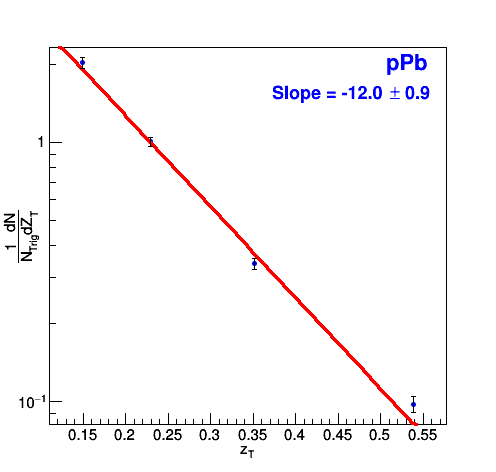

 FCN=10.2218 FROM MIGRAD    STATUS=CONVERGED      42 CALLS          43 TOTAL
                     EDM=3.59532e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.85115e+00   7.06171e-02   4.05044e-05   1.08203e-02
   2  Slope       -8.08081e+00   2.39269e-01   1.37220e-04   2.94179e-03


Info in <TCanvas::Print>: pdf file pics/pPb_FF_Fit.pdf has been created


In [1353]:
z_error = [0,0,0,0,0,0]
pPb_Fit_Plot = ROOT.TGraphErrors()#(6,np.asarray(zT_point),np.asarray(pPb_int),np.asarray(z_error),np.asarray(pPb_error)))
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (4):
    izt = i+2
    pPb_Fit_Plot.SetPoint(i,zT_point[izt],pPb_int[izt])
    pPb_Fit_Plot.SetPointError(i,0,pPb_error[izt])
pPb_Fit_Plot.Fit("expo")

pPb_canv = ROOT.TCanvas("pPbcan","pPbcan",500,500)
pPb_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot.GetXaxis().CenterTitle(1)
pPb_Fit_Plot.GetYaxis().CenterTitle(1)
pPb_Fit_Plot.Draw("AP")
latex.DrawLatex(0.78,0.85, "#color[4]{pPb}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -12.0 #pm 0.9}")
ROOT.gPad.SetLogy()
pPb_canv.Update()
pPb_canv.Draw()
pPb_canv.SaveAs("pics/pPb_FF_Fit.pdf")
#         for NBin in range(0,NBins+1):
#         ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
#         ZYAM.SetPointError(NBin,0,Z_Error)

## Fit pp

[0.063353185, 0.097191855, 0.14910469, 0.228745595, 0.35092488499999996, 0.53836348, 0.82591817]


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: ppcan


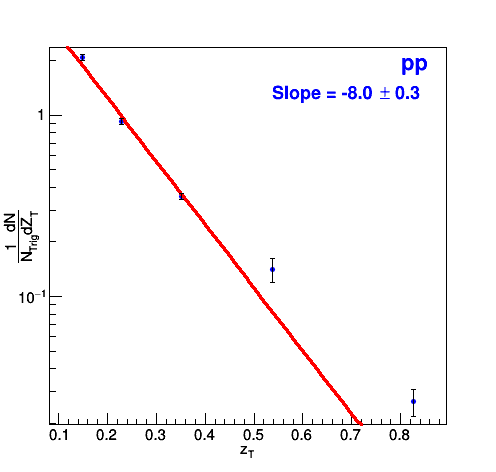

 FCN=34.3066 FROM MIGRAD    STATUS=CONVERGED      61 CALLS          62 TOTAL
                     EDM=1.10132e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.82767e+00   7.82015e-02   6.35293e-05   2.11943e-03
   2  Slope       -8.04262e+00   3.00651e-01   2.44241e-04   5.05928e-04


Info in <TCanvas::Print>: pdf file pics/pp_FF_Fit.pdf has been created


In [1373]:
pp_Fit_Plot = ROOT.TGraphErrors()#(

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)
print zT_point
for i in range (5):
    izt = i+2
    pp_Fit_Plot.SetPoint(i,zT_point[izt],pp_int[izt])
    pp_Fit_Plot.SetPointError(i,0,pp_error[izt])
pp_Fit_Plot.Fit("expo")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
pp_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pp_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pp_Fit_Plot.GetXaxis().CenterTitle(1)
pp_Fit_Plot.GetYaxis().CenterTitle(1)
pp_Fit_Plot.Draw("AP")
latex.DrawLatex(0.81,0.85, "#color[4]{pp}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -8.0 #pm 0.3}")
ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/pp_FF_Fit.pdf")
pp_Fit_Plot = ROOT.TGraphErrors()

# Divide FF

In [1355]:
#pPb/pp
Ratio = []
Ratio_Error = []
Ratio_L = []
Ratio_Error_L = []
Ratio_E = []
Ratio_Error_E = []
for ztbin in range (7):
    Ratio.append(pPb_int[ztbin]/pp_int[ztbin])
    Ratio_Error.append(math.sqrt((pp_error[ztbin]/pp_int[ztbin])**2 + (pPb_error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin])
    
    Ratio_L.append(pPb_int_L[ztbin]/pp_int_L[ztbin])
    Ratio_Error_L.append(math.sqrt((pp_error_L[ztbin]/pp_int_L[ztbin])**2 + (pPb_error_L[ztbin]/pPb_int_L[ztbin])**2)*Ratio_L[ztbin])
    
    Ratio_E.append(pPb_int_E[ztbin]/pp_int_E[ztbin])
    Ratio_Error_E.append(math.sqrt((pp_error_E[ztbin]/pp_int_L[ztbin])**2 + (pPb_error_E[ztbin]/pPb_int_E[ztbin])**2)*Ratio_E[ztbin])
    
    print "UE Error", "%1.2f"%(math.sqrt((MC_LE_Error[izt]/MC_int[ztbin])**2 + (pPb_LE_Error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)
    print "P Stat. Error", "%1.2f"%(math.sqrt((pp_P_stat_Error[izt]/pp_int[ztbin])**2 + (pPb_P_stat_Error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)
    print "Statistical Error","%1.2f"%(math.sqrt((MC_error[izt]/MC_int[ztbin])**2 + (pPb_error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)
    print Ratio[ztbin]
plt.errorbar(zT_point, Ratio, yerr=Ratio_Error, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2)
print Ratio_Error
#plt.errorbar(zT_point, Ratio_L, yerr= Ratio_Error_L, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2)
#plt.errorbar(zT_point, Ratio_E, yerr= Ratio_Error_E, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2)
plt.xlabel('${z_T}$',fontsize=20)
plt.ylabel(r"$\frac{p+Pb}{pp}$",fontsize=20)
plt.ylim((0, 3.5)) 
plt.yticks(np.arange(-0, 3.5, step=0.2))
plt.xscale('log')
plt.xlim(xmin = 0.035,xmax=1)
plt.axhline(y=1, color='r', linestyle='--')
plt.figtext(0.6,0.81,"pPb/pp NN ",color='Blue', fontsize=15)
#plt.figtext(0.6,0.75,"pPb/pp $\sigma_{long}^{2}$ ",color='Green', fontsize=15)
#plt.figtext(0.6,0.69,"pPb/pp $EMax$ ",color='Red', fontsize=15)
plt.gcf()
plt.savefig("pics/NN_L_FFunction.pdf", bbox_inches='tight')
plt.show()

UE Error 0.16
P Stat. Error 0.00
Statistical Error 6.70
1.35955187696
UE Error 0.21
P Stat. Error 0.00
Statistical Error 6.01
1.37193989823
UE Error 0.26
P Stat. Error 0.00
Statistical Error 5.24
0.971422168645
UE Error 0.36
P Stat. Error 0.00
Statistical Error 7.92
1.08269858694
UE Error 0.52
P Stat. Error 0.00
Statistical Error 18.86
0.954435284583
UE Error 0.92
P Stat. Error 0.00
Statistical Error 20.30
0.694432661462


IndexError: list index out of range

# Dived pPb/MC

7.18336377618
6.31945891053
6.27650568895
5.4541044376
6.21185424209
17.0348227576
22.4238329954
[0.09766155704801581, 0.08669917814556982, 0.06097136767867174, 0.0590515116762356, 0.059288128713384125, 0.11829537305085362, 0.2086205032170382]


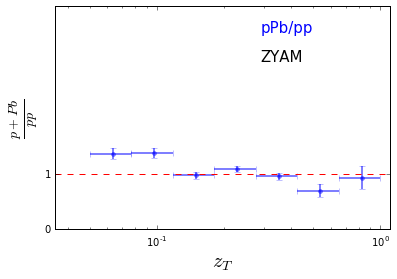

In [1357]:
#pPb/pp
Ratio = []
Ratio_Error = []
for ztbin in range (7):
    #Ratio.append(pPb_int[ztbin]/MC_int[ztbin])
    #Ratio_Error.append(math.sqrt((MC_error[ztbin]/MC_int[ztbin])**2 + (pp_error[ztbin]/pp_int[ztbin])**2)*Ratio[ztbin])
    Ratio.append(pPb_int[ztbin]/pp_int[ztbin])
    Ratio_Error.append(math.sqrt((pp_error[ztbin]/pp_int[ztbin])**2 + (pPb_error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin])
    print (Ratio_Error[ztbin]/Ratio[ztbin])*100
    
#     print "UE Error", "%1.2f"%(math.sqrt((pp_LE_Error[izt]/pp_int[ztbin])**2 + (pPb_LE_Error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)
#     print "P Stat. Error", "%1.2f"%(math.sqrt((pp_P_stat_Error[izt]/pp_int[ztbin])**2 + (pPb_P_stat_Error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)
#     print "Statistical Error","%1.2f"%(math.sqrt((pp_error[izt]/pp_int[ztbin])**2 + (pPb_error[ztbin]/pPb_int[ztbin])**2)*Ratio[ztbin] * 100)
#     print Ratio[ztbin]
print Ratio_Error
plt.errorbar(zT_point, Ratio, yerr=Ratio_Error,xerr=zT_width, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2)
#plt.errorbar(zT_point, Ratio_L, yerr= Ratio_Error_L, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2)
#plt.errorbar(zT_point, Ratio_E, yerr= Ratio_Error_E, fmt='.',alpha = 0.5,capsize=3, ms=8,lw=2)
plt.xlabel('${z_T}$',fontsize=20)
plt.ylabel(r"$\frac{p+Pb}{pp}$",fontsize=20)
plt.ylim((0, 4)) 
plt.yticks(np.arange(-0, 2, step=1))
plt.xscale('log')
plt.xlim(xmin = 0.035,xmax=1.1)
plt.axhline(y=1, color='r', linestyle='--')
plt.figtext(0.6,0.81,"pPb/pp",color='Blue', fontsize=15)
plt.figtext(0.6,0.71,"ZYAM",color='Black', fontsize=15)
#plt.figtext(0.6,0.69,"pPb/pp $EMax$ ",color='Red', fontsize=15)
plt.gcf()
plt.savefig("pics/NN_MC_FFunction.pdf", bbox_inches='tight')
plt.show()

# Overlay pPb and pp

In [ ]:
#prefix ='13def'

In [ ]:
def MC_DATA(Region):

        File1 = 'InputData/13def_SE_GMB_new_Ratio.root'
        prfx1 = '13def'

        File2 = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
        prfx2 = 'pp'

        File3 = 'InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root'
        prfx3 = "18b10a"           
    
        Uncorr = False
        DoZyam = True
        DoSub = False
        DoSys = True
        
        ptbin = 0
        ptbin = ptbin+2;
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),3500,2500)
        hstack = []
        #canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1000,800)
        
        if (Region=="regions"):
            #canvases.Divide(4,3)
            canvases.Divide(3,3)
        elif(Region=="inclusive"):
            canvases.Divide(3,2)
            
        for ztbin in range(0,7):
                
            if (Region=="regions"):              
            #grab
                hstack.append(ROOT.THStack("hs_%i"%(ztbin),"#gamma-hadron: p_{T}^{Clus.}(%1.2f-%1.0f) z_{T}(%1.2f-%1.2f)"
                                             %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1])))
                
                hsig3 = GetPhiProj(MC_File,prfx3,ptbin,ztbin,True,True,False) #[DNN],[Subtraction Bool][DoSys]
                hsig3.SetFillColor(7)
                hsig1,htemp,NTrig1 = GetBKGsubtracted(pPb_File,prfx1,ptbin,ztbin,True,DoSub,False)#doZYAM,doSubtraction,dosys 
                hsig1_sys,htemp1,NTrigtemp = GetBKGsubtracted(pPb_File,prfx1,ptbin,ztbin,True,DoSub,False)
                hsig1.SetMarkerColor(2)
                hsig1.SetLineColor(2)
                hsig1_sys.SetLineColor(2)
                
                hsig2,htemp,NTrig2 = GetBKGsubtracted(pp_File,prfx2,ptbin,ztbin,True,DoSub,False)#doZYAM,doSubtraction,dosys 
                hsig2_sys,htemp2,NTrigtemp = GetBKGsubtracted(pp_File,prfx2,ptbin,ztbin,True,DoSub,False)
                hsig2_sys.SetLineColor(4)
                hsig2.SetMarkerColor(4)
                hsig2.SetLineColor(4)
                
                ymax = 1.2*max(hsig3.GetMaximum(),hsig2.GetMaximum())
                ymin = -1.4*abs(min(hsig3.GetMinimum(),hsig2.GetMinimum()))
                hsig1.GetYaxis().SetRangeUser(ymin,ymax)
                hsig2.GetYaxis().SetRangeUser(ymin,ymax)    
                #canvases.cd(ztbin*2+1)
                
                canvases.cd(ztbin+1)
                ROOT.gPad.SetLeftMargin(0.18)
                ROOT.gPad.SetRightMargin(0.0)
                hstack[ztbin].Add(hsig3,"E3")
                hstack[ztbin].Add(hsig1)
                hstack[ztbin].Add(hsig2)
                hstack[ztbin].Draw("nostack")
                hstack[ztbin].GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
                hstack[ztbin].GetYaxis().SetTitleSize(0.05)
                hstack[ztbin].GetYaxis().SetTitleOffset(1.5)
                hstack[ztbin].GetXaxis().SetTitle("#Delta#phi")
                hstack[ztbin].GetXaxis().CenterTitle(1)
                hstack[ztbin].GetXaxis().SetTitleOffset(0.6)
                hstack[ztbin].GetXaxis().SetTitleSize(0.06)
                #hstack.Clear()
                Sig_ZYAM= ZYAM_Line(hsig2) #Change to UnCorr_Line, swith to high rapidity
                LE_sig,legend = GetLEProj(File2, ptbin, ztbin,True)
                LE_Line,temp = GetLE_Line(LE_sig)
                #hsig1_sys.Draw("same")
                #hsig1.Draw("same")  
                #DrawLabel2(True)
                
                latex = TLatex()
                latex.SetNDC()
                latex.SetTextSize(0.03)
                latex.DrawLatex(0.2,0.85, "#color[2]{pPb+Pbp UE-Subtracted}")
                latex.DrawLatex(0.2,0.80, "#color[4]{pp UE-Subtracted}")
                latex.DrawLatex(0.2,0.75, "#color[7]{pp MC: g-jet}")
                
    
            if (Region=="inclusive"):
                    hsig1 = GetPhiProj(RootFile,ptbin,ztbin,"inclusive",False,False)
                    ymax = 1.2*hsig.GetMaximum()
                    hsig1.GetYaxis().SetRangeUser(0,ymax)
                    canvases.cd(ztbin+1) 
                    #hsig1.Draw()  
                    DrawLabel2("inclusive")                  
                
            if (Region=="regions"):
                #hsig2_sys.SetFillColor(19)
                #hsig2_sys.Draw("Same")
                #hsig2.Draw("same")
                #DrawLabel2(False)
                hsig3.SetLineColor(3)
                #hsig3.Draw("same")
            
                
        canvases.Update()
        canvases.Draw()
        if (Region=="inclusive"):
            canvases.SaveAs("pics/%s_Inclusive_Phi_OVERLAY.pdf"%(prefix))
            canvases.SaveAs("pics/%s_Inclusive_Phi_OVERLAY.png"%(prefix))
        if (Region=="regions"):
            if(Uncorr):
                canvases.SaveAs("pics/pp_pPb_UE.pdf")
            else:
                canvases.SaveAs("pics/pp_pPb_MC_Full_Sub.pdf")
        return canvases
#myText(.2,.2,"hello_%i"%number,1)

In [ ]:
MC_DATA("regions")

# Compare Gustavo

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c


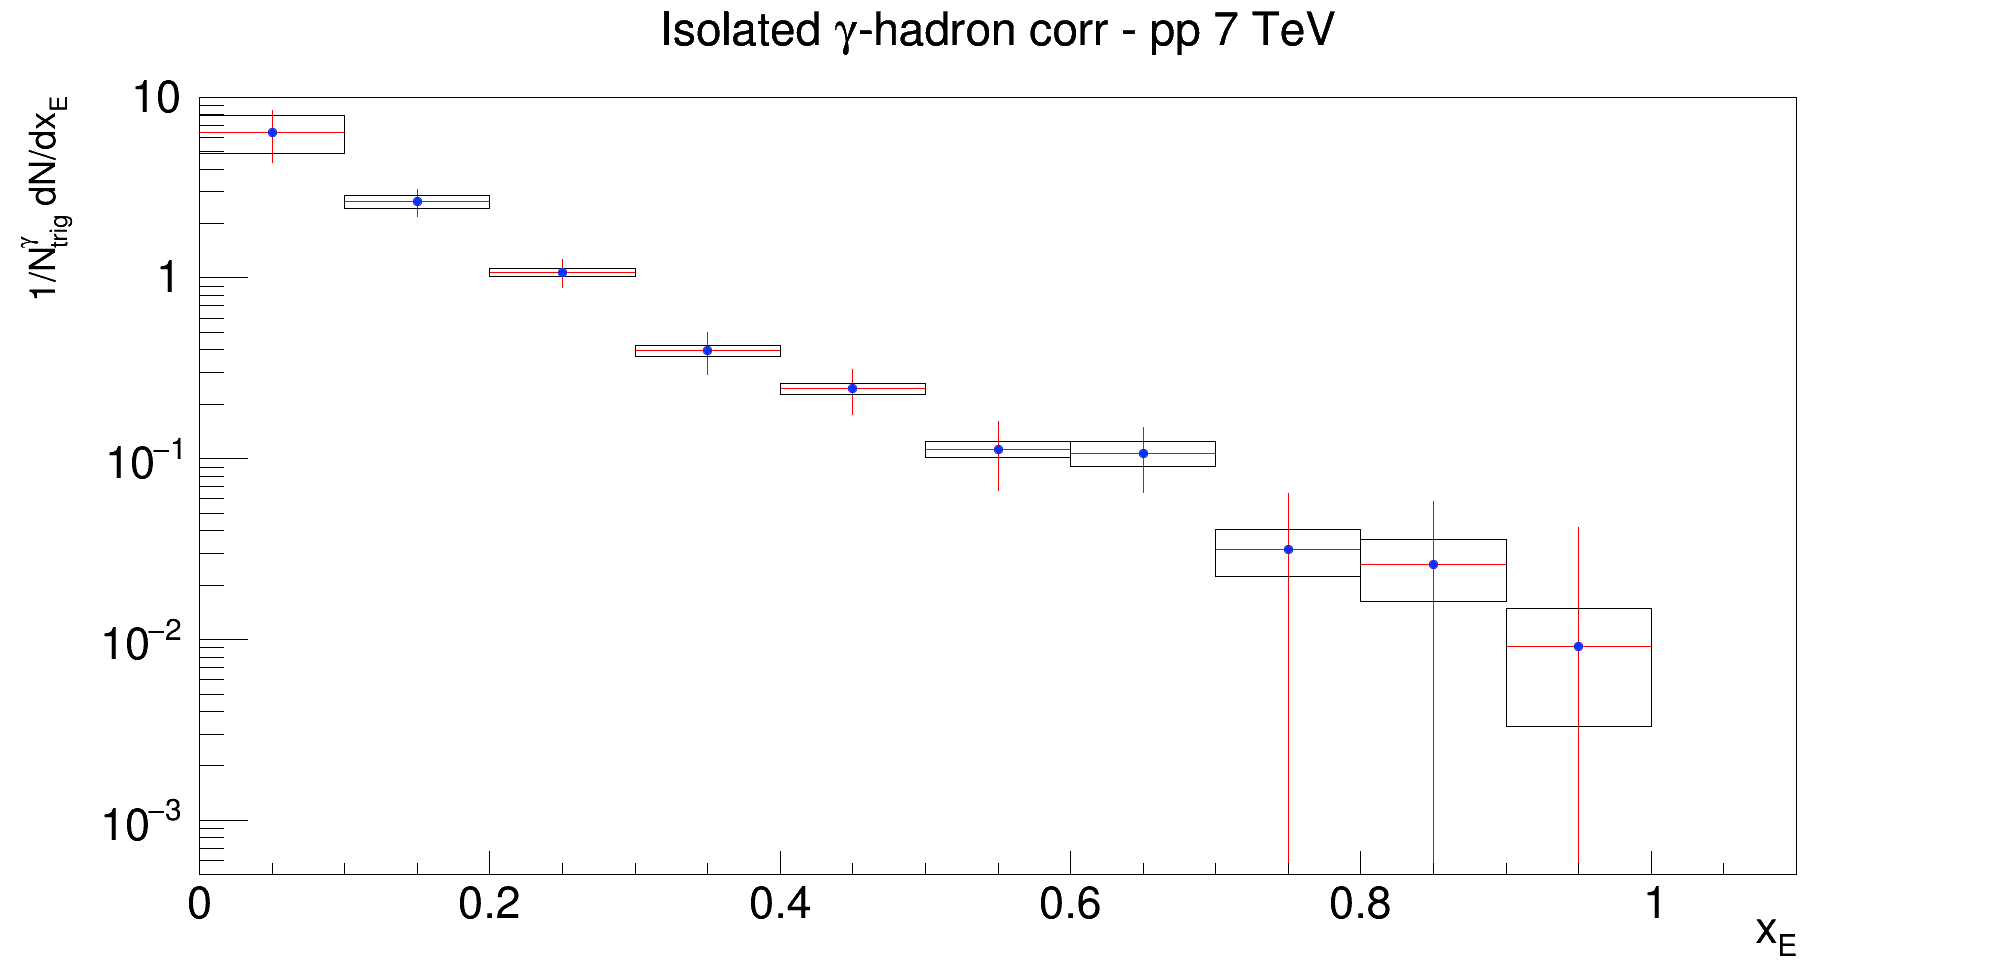

1 0.05
2 0.15
3 0.25
4 0.35
5 0.45
6 0.55
7 0.65
8 0.75
9 0.85
10 0.95
11 1.05
12 1.15
13 1.25
14 1.35
15 1.45
16 1.55
17 1.65
18 1.75
19 1.85
20 1.95
width  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
[0.05, 0.15000000000000002, 0.25, 0.35000000000000003, 0.45, 0.55, 0.6500000000000001, 0.7500000000000001, 0.8500000000000001, 0.9500000000000001, 1.05, 1.1500000000000001, 1.2500000000000002, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.7500000000000002, 1.85, 1.9500000000000002]
TFile**		InputData/pp7TeV.root	
 TFile*		InputData/pp7TeV.root	
  KEY: TH1D	h_xEClusterTot;1	
  KEY: TH1D	h_xEPi0Tot;1	
  KEY: TH1D	h_xEUETot;1	
  KEY: TH1D	h_pClusterTot;1	Total x_{E} distribution for isolated cluster with purity scaling
  KEY: TH1D	h_pPi0Tot;1	Total x_{E} distribution for isolated #pi^{0} with purity scaling
  KEY: TH1D	h_pxEUETot;1	projection de la distribution en xE et pTtrig pour l'UE
  KEY: TH1F	h_xEClus

In [1399]:
file = ROOT.TFile("InputData/pp7TeV.root")
file.ls()
pp7 = file.Get("h_xEphotonTot")
pp7_sys = file.Get("Syst")
c = ROOT.TCanvas("c","c",2000,1000)
pp7.Draw()
pp7_sys.SetFillColor(0)
ROOT.gPad.SetLogy()
pp7_sys.SetLineColor(1)
pp7_sys.Draw("sameE2")
c.Draw()
nbins = pp7.GetSize()-2 
pp7_data = []
pp7_x = []
pp7_error = []
pp7_width = []
#pp7.Scale(6.0)
for i in range (1,nbins+1):
    print i,pp7.GetBinCenter(i)
    pp7_data.append(pp7.GetBinContent(i))
    pp7_x.append(pp7.GetBinCenter(i))
    pp7_error.append(pp7.GetBinError(i))
    pp7_width.append(pp7.GetXaxis().GetBinWidth(i)/2)
print "width ",pp7_width
print pp7_x

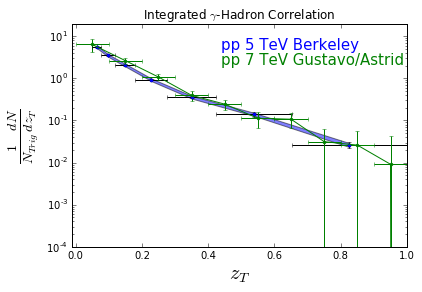

In [1402]:
pp_int, pp_error = FF('InputData/17q_SE_NN_Correlation_GMB_Ratio.root','pp',False)
pp_int_sys, pp_error_sys = FF('InputData/17q_SE_NN_Correlation_GMB_Ratio.root','pp',True)
pPb_int, pPb_error = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',False)
pPb_int_sys, pPb_error_sys = FF('InputData/13def_SE_GMB_new_Ratio.root','13def',True)
#MC_int, MC_error = FF('InputData/18b10a_calo_pthat1to2_SE_Correlation.root', '18b10a')
#MC_int, MC_error = FF('InputData/18b10a_pthat_1_2_SE_L0_Correlation_GMB_Ratio.root', '18b10a')
%matplotlib inline
plt.errorbar(zT_point, pp_int, yerr=pp_error,xerr=zT_width, fmt='k.',capsize=2)
plt.fill_between(zT_point, np.asarray(pp_int)-np.asarray(pp_error_sys), np.asarray(pp_int)+np.asarray(pp_error_sys),interpolate=False, alpha=0.5,facecolor='blue')
plt.errorbar(zT_point, pp_int,yerr=pp_error_sys, ecolor='b',fmt='b.',capsize=0)
plt.errorbar(pp7_x,pp7_data,yerr=pp7_error, xerr = 0.05,fmt='g.-',capsize=2)
#plt.errorbar(pp7_x,pp7_data,yerr=pp7_error,fmt='gl',capsize=2)
#plt.errorbar(zT_point, pPb_int, yerr=pPb_error, fmt='k.',capsize=2)
#plt.errorbar(zT_point, pPb_int,yerr=pPb_error_sys, ecolor='r',fmt='r.',capsize=0)
#plt.fill_between(zT_point, np.asarray(pPb_int)-np.asarray(pPb_error_sys), np.asarray(pPb_int)+np.asarray(pPb_error_sys),interpolate=False, alpha=0.5,facecolor='red')
#plt.plot(zT_point,MC_int,'co')
#plt.errorbar(zT_point, MC_int, yerr=pp_error, fmt='cs')
plt.yscale('log')
#plt.xscale('log')
plt.ylabel(r"$\frac{1}{N_{Trig}}\frac{dN}{dz_{T}}$",fontsize=20)
plt.xlabel('${z_T}$',fontsize=20)
plt.xlim(xmin = -0.01,xmax=1.0)
plt.ylim(ymin = 0.0001,ymax=20)
#plt.figtext(0.4,0.81,"pythia $\gamma$-j",color='Cyan', fontsize=15)
plt.figtext(0.47,0.76,"pp 7 TeV Gustavo/Astrid",color='Green', fontsize=15)
plt.figtext(0.47,0.811,"pp 5 TeV Berkeley",color='Blue', fontsize=15)
plt.title('Integrated $\gamma$-Hadron Correlation ')
#plt.figure.set_size_inches(18.5, 10.5)
#plt.figure(num=None, figsize=(12, 10), dpi=180, facecolor='w', edgecolor='k')
plt.gcf()
plt.savefig("pics/Gustavo_FFunction.pdf", bbox_inches='tight')
plt.show()


### Fit Gustavo

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: ppcan


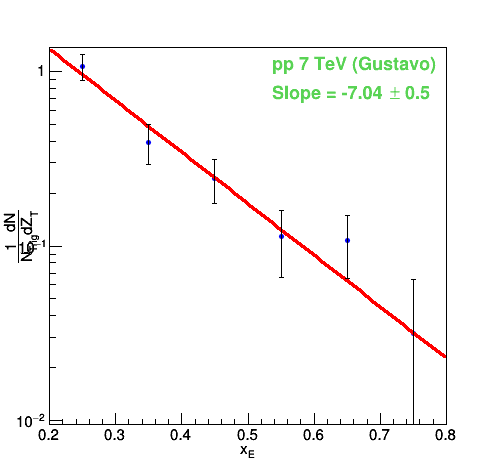

 FCN=2.32448 FROM MIGRAD    STATUS=CONVERGED      43 CALLS          44 TOTAL
                     EDM=5.97656e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.66143e+00   4.09638e-01   1.04622e-04   8.99269e-03
   2  Slope       -6.81282e+00   1.07776e+00   2.75510e-04   3.53205e-03


Info in <TCanvas::Print>: pdf file pics/pp7_FF_Fit.pdf has been created


In [1385]:
Gus_pp_Fit_Plot = ROOT.TGraphErrors()

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (6):
    izt = i+2
    pp_Fit_Plot.SetPoint(i,pp7_x[izt],pp7_data[izt])
    pp_Fit_Plot.SetPointError(i,0,pp7_error[izt])
pp_Fit_Plot.Fit("expo")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
pp_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pp_Fit_Plot.GetXaxis().SetTitle("x_{E}")
pp_Fit_Plot.GetXaxis().CenterTitle(1)
pp_Fit_Plot.GetYaxis().CenterTitle(1)
pp_Fit_Plot.Draw("AP")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.85, "#color[8]{pp 7 TeV (Gustavo)}")
latex.DrawLatex(0.55,0.79, "#color[8]{Slope = -7.04 #pm 0.5}")
ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/pp7_FF_Fit.pdf")
pp_Fit_Plot = ROOT.TGraphErrors()

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: ppcan


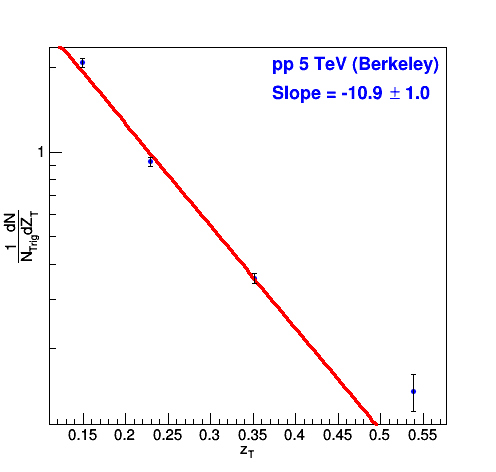

 FCN=16.6945 FROM MIGRAD    STATUS=CONVERGED      54 CALLS          55 TOTAL
                     EDM=6.98071e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.90924e+00   7.43425e-02   4.51509e-05   4.36083e-03
   2  Slope       -8.38619e+00   2.90639e-01   1.76508e-04   1.30328e-03


Info in <TCanvas::Print>: pdf file pics/pp_FF_Fit.pdf has been created


In [1383]:
pp_Fit_Plot = ROOT.TGraphErrors()#(

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (4):
    izt = i+2
    pp_Fit_Plot.SetPoint(i,zT_point[izt],pp_int[izt])
    pp_Fit_Plot.SetPointError(i,0,pp_error[izt])
pp_Fit_Plot.Fit("expo")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
pp_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pp_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pp_Fit_Plot.GetXaxis().CenterTitle(1)
pp_Fit_Plot.GetYaxis().CenterTitle(1)
pp_Fit_Plot.Draw("AP")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.85, "#color[4]{pp 5 TeV (Berkeley)}")
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -10.9 #pm 1.0}")
ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/pp_FF_Fit.pdf")
pp_Fit_Plot = ROOT.TGraphErrors()